Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 21

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=21
num_BackTrack_Days=2

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=12 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
## DROP_N=550 => 25/07/2021
## DROP_N=675 => 31/10/2021
#
drop_n_dataset_days=675
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
255                                           NaN                 Tunisia   
256                                           NaN                  Turkey   
257                                           NaN           United States   
258                                           NaN                  Uganda   
259                                           NaN                 Ukraine   
260                                           NaN    United Arab Emirates   
261                                      Anguilla          United Kingdom   
262                                       Bermuda          United Kingdom   
263                        British Virgin Islands          United Kingdom   
264                                Cayman Islands          United Kingdom   
265                               Channel Islands          United Kingdom   
266                   Falkland Islands (Malvinas)          United Kingdom   
267                                     Gibraltar          United Kingdom   
268                                      Guernsey          United Kingdom   
269                                   Isle of Man          United Kingdom   
270                                        Jersey          United Kingdom   
271                                    Montserrat          United Kingdom   
272  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
273                      Turks and Caicos Islands          United Kingdom   
274                                           NaN          United Kingdom   
275                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
261                                           NaN                 Tunisia   
262                                           NaN                  Turkey   
263                                           NaN           United States   
264                                           NaN                  Uganda   
265                                           NaN                 Ukraine   
266                                           NaN    United Arab Emirates   
267                                      Anguilla          United Kingdom   
268                                       Bermuda          United Kingdom   
269                        British Virgin Islands          United Kingdom   
270                                Cayman Islands          United Kingdom   
271                               Channel Islands          United Kingdom   
272                   Falkland Islands (Malvinas)          United Kingdom   
273                                     Gibraltar          United Kingdom   
274                                      Guernsey          United Kingdom   
275                                   Isle of Man          United Kingdom   
276                                        Jersey          United Kingdom   
277                                    Montserrat          United Kingdom   
278  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
279                      Turks and Caicos Islands          United Kingdom   
280                                           NaN          United Kingdom   
281                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  7/31/22  8/1/22  8/2/22  8/3/22  \
185        0        0        0        0  ...      307     307     307     307   
186        0        0        0        0  ...      739     739     739     739   
187        0        0        0        0  ...      794     794     794     795   
188        0        0        0        0  ...        0       0       0       0   
189        0        0        0        0  ...      992     992     992     992   
190        0        0        0        0  ...     1013    1013    1013    1013   
191        0        0        0        0  ...   327525  327755  327883  328006   
192        0        0        0        0  ...        4       4      10      11   
193        0        0        0        0  ...    11608   11608   11608   11630   
194        0        0        0        0  ...       61      61      61      61   

     8/4/22  8/5/22  8/6/22  8/7/22   Population                 region  
185     307     307     307     307       540,544          Maldives_nan  
186     739     739     739     739    20,250,833              Mali_nan  
187     795     795     795     795       441,543             Malta_nan  
188       0       0       0       0           NaN  Marshall Islands_nan  
189     992     992     992     992     4,649,658        Mauritania_nan  
190    1013    1015    1015    1015     1,273,985         Mauritius_nan  
191  328128  328128  328306  328306   128,640,794            Mexico_nan  
192      11      12      12      16           NaN        Micronesia_nan  
193   11630   11630   11630   11630     4,035,942           Moldova_nan  
194      61      61      61      61        39,183            Monaco_nan  

[10 rows x 935 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  1/22/20  1/23/20  \
175            NaN     Micronesia   7.425600  150.55080        0        0   
176            NaN        Moldova  47.411600   28.36990        0        0   
177            NaN         Monaco  43.733300    7.41670        0        0   
178            NaN       Mongolia  46.862500  103.84670        0        0   
179            NaN     Montenegro  42.708678   19.37439        0        0   
180            NaN        Morocco  31.791700   -7.09260        0        0   
181            NaN     Mozambique -18.665700   35.52960        0        0   
182            NaN        Namibia -22.957600   18.49040        0        0   
183            NaN          Nepal  28.166700   84.25000        0        0   
184          Aruba    Netherlands  12.521100  -69.96830        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  7/31/22  8/1/22  8/2/22  8/3/22  \
175        0        0        0        0  ...        0       0       0       0   
176        0        0        0        0  ...        0       0       0       0   
177        0        0        0        0  ...        0       0       0       0   
178        0        0        0        0  ...        0       0       0       0   
179        0        0        0        0  ...        0       0       0       0   
180        0        0        0        0  ...        0       0       0       0   
181        0        0        0        0  ...        0       0       0       0   
182        0        0        0        0  ...        0       0       0       0   
183        0        0        0        0  ...        0       0       0       0   
184        0        0        0        0  ...        0       0       0       0   

     8/4/22  8/5/22  8/6/22  8/7/22   Population              region  
175       0       0       0       0           NaN     Micronesia_nan  
176       0       0       0       0     4,035,942        Moldova_nan  
177       0       0       0       0        39,183         Monaco_nan  
178       0       0       0       0     3,278,290       Mongolia_nan  
179       0       0       0       0       622 500     Montenegro_nan  
180       0       0       0       0    36,817,128        Morocco_nan  
181       0       0       0       0    31,542,919     Mozambique_nan  
182       0       0       0       0     2,540,905        Namibia_nan  
183       0       0       0       0    29,300,000          Nepal_nan  
184       0       0       0       0       116,600  Netherlands_Aruba  

[10 rows x 935 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  7/31/22   8/1/22   8/2/22  \
185        0        0        0        0  ...   184302   184485   184485   
186        0        0        0        0  ...    31228    31228    31230   
187        0        0        0        0  ...   112828   112879   112973   
188        0        0        0        0  ...       64       66       66   
189        0        0        0        0  ...    62572    62579    62592   
190        0        0        0        0  ...   244850   244850   244850   
191        0        0        0        0  ...  6711847  6761149  6782980   
192        0        0        0        0  ...     4321     4321     5444   
193        0        0        0        0  ...   532187   532187   532187   
194        0        0        0        0  ...    14059    14129    14129   

      8/3/22   8/4/22   8/5/22   8/6/22   8/7/22   Population   \
185   184485   184485   184485   184485   184485       540,544   
186    31232    31232    31234    31236    31236    20,250,833   
187   113056   113120   113170   113220   113246       441,543   
188       66       68       68       68       70           NaN   
189    62615    62631    62645    62652    62657     4,649,658   
190   244850   244850   248720   248720   248720     1,273,985   
191  6803190  6821746  6821746  6854180  6854180   128,640,794   
192     6291     6291     6507     6507     6691           NaN   
193   541715   541715   541715   541715   541715     4,035,942   
194    14138    14157    14174    14174    14174        39,183   

                   region  
185          Maldives_nan  
186              Mali_nan  
187             Malta_nan  
188  Marshall Islands_nan  
189        Mauritania_nan  
190         Mauritius_nan  
191            Mexico_nan  
192        Micronesia_nan  
193           Moldova_nan  
194            Monaco_nan  

[10 rows x 935 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Philippines  12.879721  121.774017   
221            NaN                            Poland  51.919400   19.145100   
222            NaN                          Portugal  39.399900   -8.224500   
223            NaN                             Qatar  25.354800   51.183900   
224            NaN                           Romania  45.943200   24.966800   
225            NaN                            Russia  61.524010  105.318756   
226            NaN                            Rwanda  -1.940300   29.873900   
227            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
228            NaN                       Saint Lucia  13.909400  -60.978900   
229            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...   7/31/22  \
220        0        0        0        0        0        0  ...   3776627   
221        0        0        0        0        0        0  ...   6069665   
222        0        0        0        0        0        0  ...   5340612   
223        0        0        0        0        0        0  ...    408656   
224        0        0        0        0        0        0  ...   3063647   
225        0        0        0        0        0        0  ...  18330786   
226        0        0        0        0        0        0  ...    132239   
227        0        0        0        0        0        0  ...      6462   
228        0        0        0        0        0        0  ...     27966   
229        0        0        0        0        0        0  ...      9354   

       8/1/22    8/2/22    8/3/22    8/4/22    8/5/22    8/6/22    8/7/22  \
220   3780178   3782822   3785869   3790309   3795008   3799334   3803955   
221   6070282   6075927   6080398   6084876   6089166   6093571   6094269   
222   5345143   5349218   5353103   5356285   5359624   5359624   5359624   
223    409622    410568    411405    412137    412897    413489    414310   
224   3068849   3080545   3089651   3098268   3106033   3112474   3115992   
225  18341459  18350864  18365348  18382278  18400593  18420288  18440314   
226    132242    132267    132280    132285    132299    132299    132299   
227      6462      6464      6467      6470      6470      6477      6477   
228     27966     27966     27966     28062     28161     28161     28161   
229      9354      9370      9370      9378      9390      9390      9390   

      Population                                 region  
220   104,900,000                       Philippines_nan  
221    37,980,000                            Poland_nan  
222    10,290,000                          Portugal_nan  
223     2,870,256                             Qatar_nan  
224    19,530,000                           Romania_nan  
225   144,500,000                            Russia_nan  
226    12,952,218                            Rwanda_nan  
227        53,673             Saint Kitts and Nevis_nan  
228       184,106                       Saint Lucia_nan  
229       110,940  Saint Vincent and the Grenadines_nan  

[10 rows x 935 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

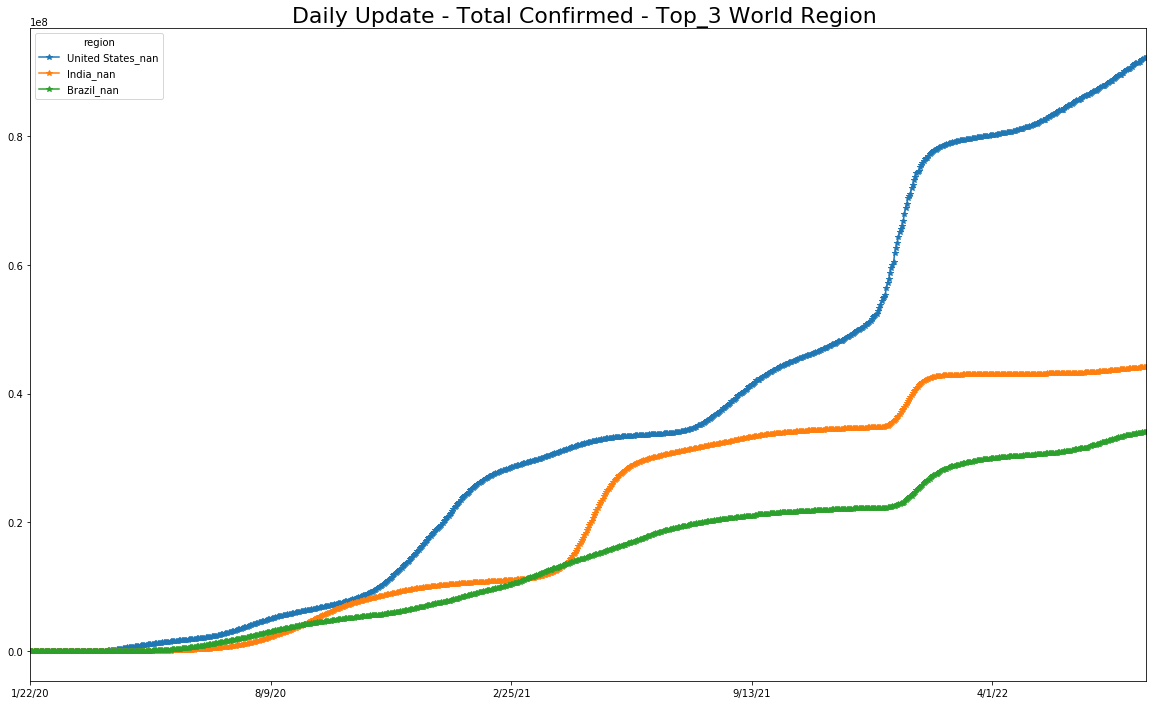

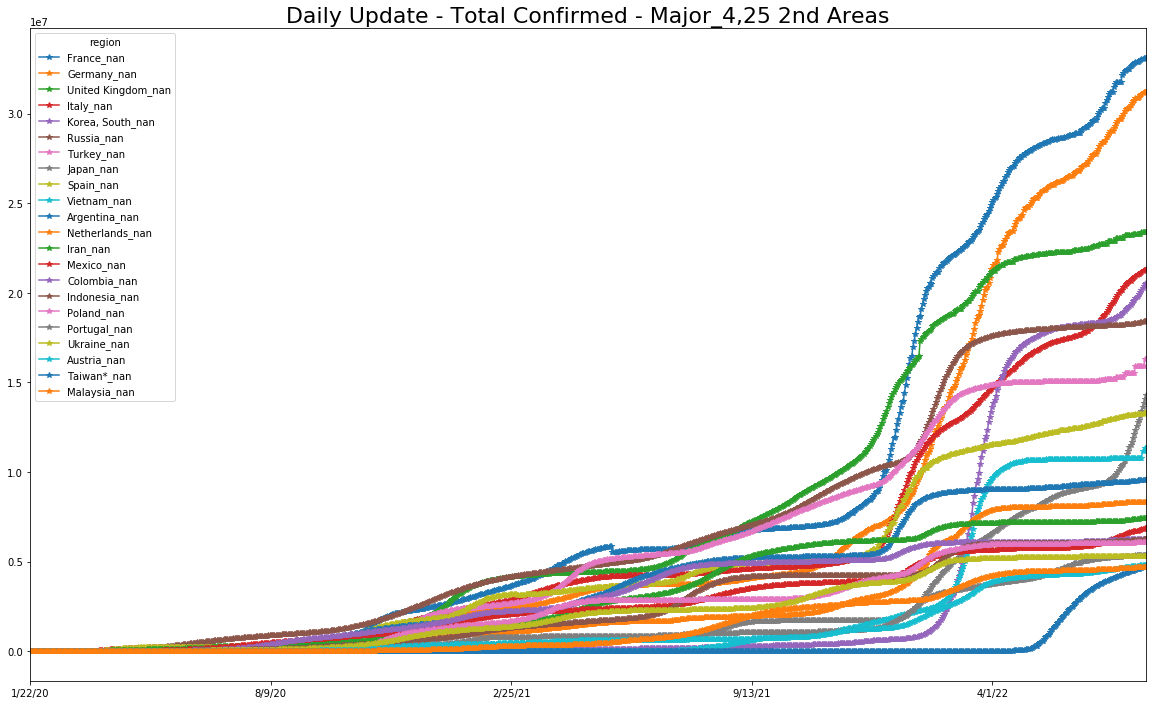

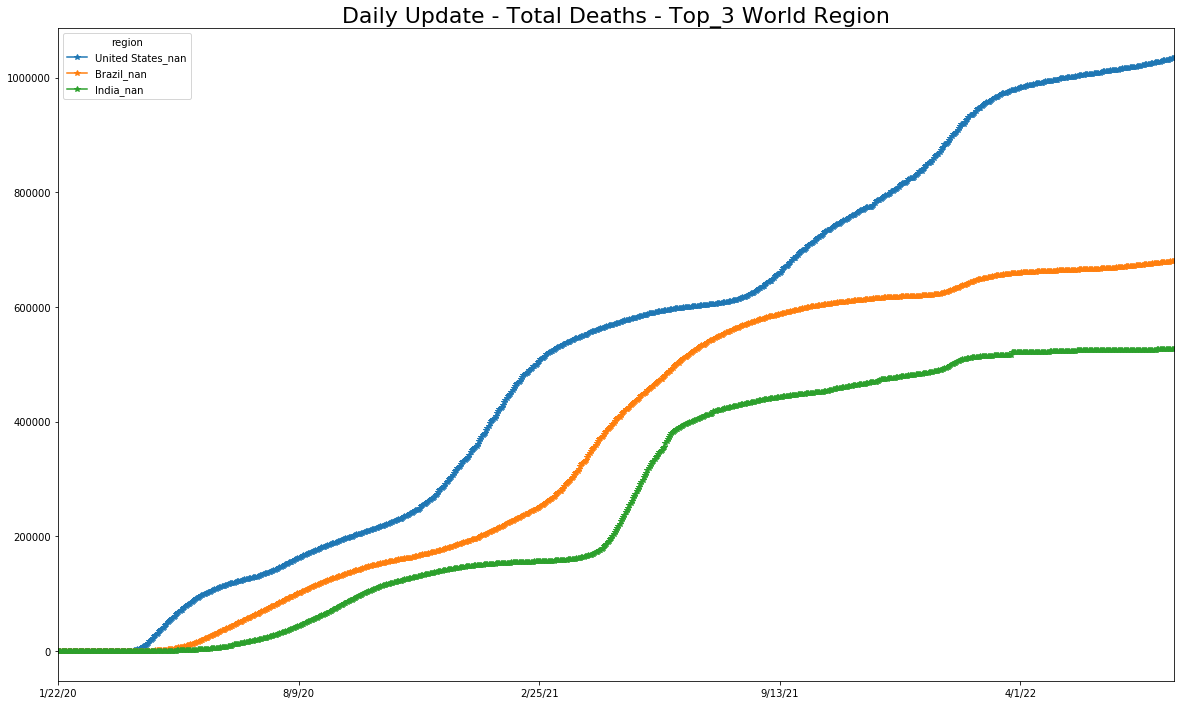

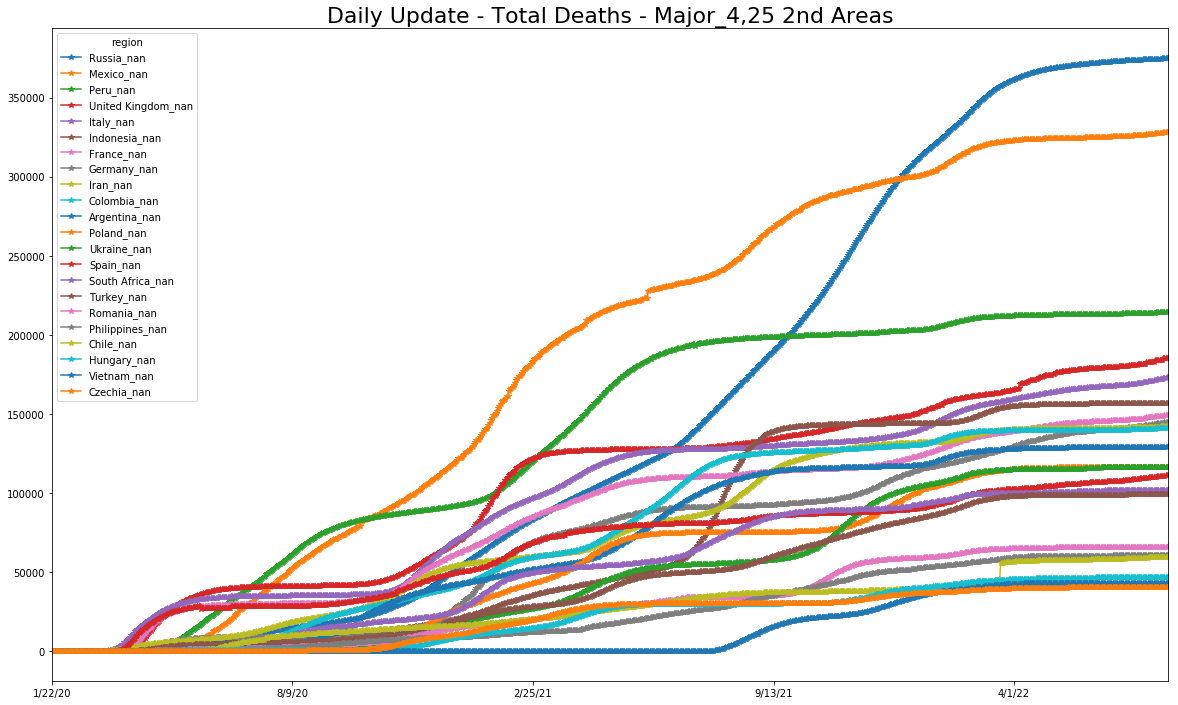

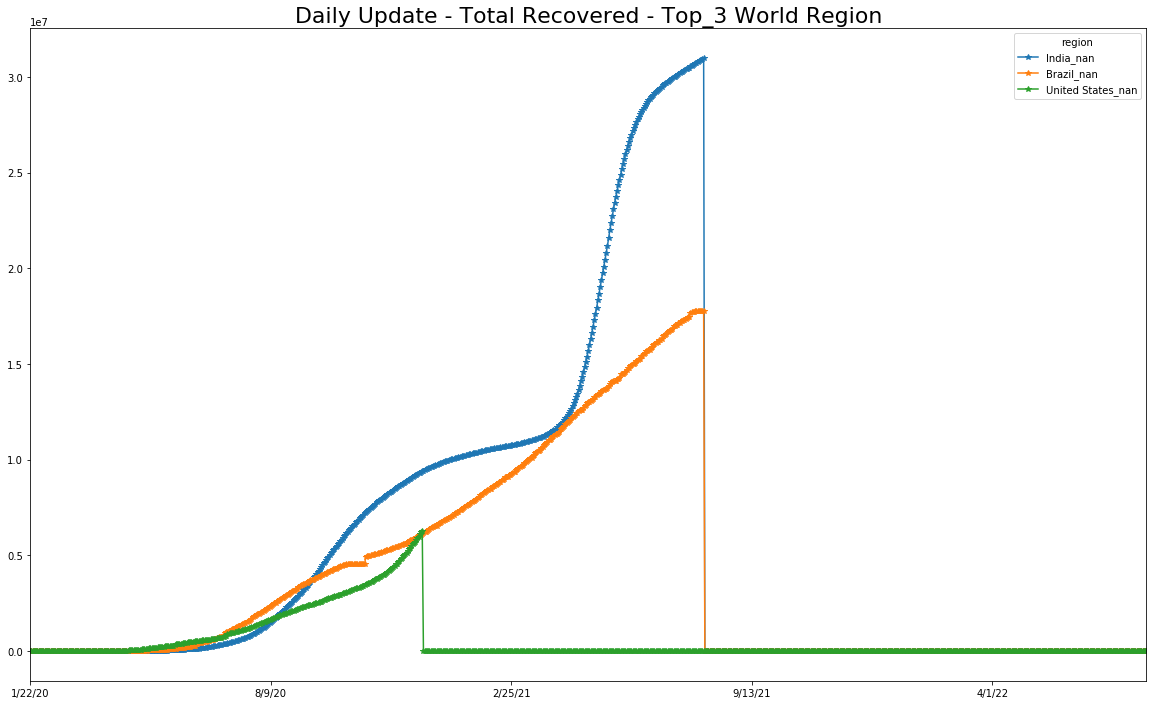

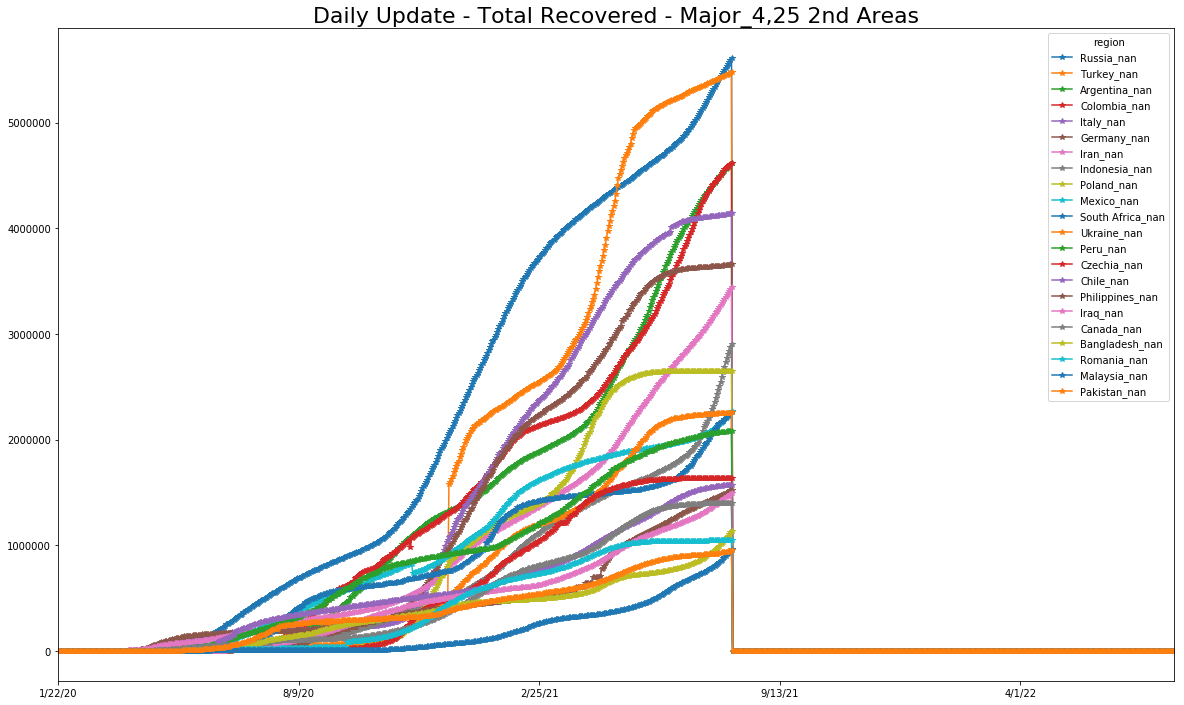

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/08/08


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/27/21           157190       199137       209980        16712       65139   
11/28/21           157218       199555       210152        16712       65144   
11/29/21           157260       199750       210344        16712       65155   

region    Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/27/21               0                     4141        5325560       337522   
11/28/21               0                     4141        5326448       337931   
11/29/21               0                     4141        5328416       338120   

region    Australia_Australian Capital Territory  ...  Uruguay_nan  \
11/27/21                                    2117  ...       399181   
11/28/21                                    2124  ...       399348   
11/29/21                                    2130  ...       399504   

region    Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
11/27/21          192599            6         430046      1197404   
11/28/21          192831            6         430696      1210340   
11/29/21          193065            6         431296      1224110   

region    West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
11/27/21                  459479                         0       9981   
11/28/21                  459479                         0       9987   
11/29/21                  460053                         0       9995   

region    Zambia_nan  Zimbabwe_nan  
11/27/21      210138        133836  
11/28/21      210143        133951  
11/29/21      210150        134226  

[3 rows x 285 columns]

In [25]:
ts[-4:]

region  Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
8/4/22           186697       315337       267902        45793      102301   
8/5/22           187037       316145       268033        45793      102636   
8/6/22           187109       316976       268141        45793      102636   
8/7/22           187442       317514       268254        45793      102636   

region  Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
8/4/22              11                     8773        9560307       426799   
8/5/22              11                     8773        9560307       426799   
8/6/22              11                     8773        9560307       426799   
8/7/22              11                     8787        9602534       426799   

region  Australia_Australian Capital Territory  ...  Uruguay_nan  \
8/4/22                                  194215  ...       971728   
8/5/22                                  194705  ...       971728   
8/6/22                                  195115  ...       971728   
8/7/22                                  195621  ...       971728   

region  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
8/4/22          243232        11730         537177     11189968   
8/5/22          243256        11731         537487     11192043   
8/6/22          243294        11731         538155     11346137   
8/7/22          243328        11731         538435     11347518   

region  West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
8/4/22                  691065                       535      11895   
8/5/22                  691065                       535      11895   
8/6/22                  691065                       535      11895   
8/7/22                  691065                       535      11895   

region  Zambia_nan  Zimbabwe_nan  
8/4/22      330575        256444  
8/5/22      331074        256444  
8/6/22      331074        256444  
8/7/22      331358        256447  

[4 rows x 285 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-11-28  Afghanistan_nan     157218             0             0   
2     2021-11-29  Afghanistan_nan     157260            28             0   
3     2021-11-30  Afghanistan_nan     157289            42             0   
4     2021-12-01  Afghanistan_nan     157359            29            99   
5     2021-12-02  Afghanistan_nan     157387            70           141   
6     2021-12-03  Afghanistan_nan     157412            28           127   
7     2021-12-04  Afghanistan_nan     157431            25           123   
8     2021-12-05  Afghanistan_nan     157454            19            72   
9     2021-12-06  Afghanistan_nan     157499            23            67   
10    2021-12-07  Afghanistan_nan     157508            45            87   
11    2021-12-08  Afghanistan_nan     157542             9            77   
12    2021-12-09  Afghanistan_nan     157585            34            88   
13    2021-12-10  Afghanistan_nan     157603            43            86   
14    2021-12-11  Afghanistan_nan     157611            18            95   
15    2021-12-12  Afghanistan_nan     157633             8            69   
16    2021-12-13  Afghanistan_nan     157648            22            48   
17    2021-12-14  Afghanistan_nan     157660            15            45   
18    2021-12-15  Afghanistan_nan     157665            12            49   
19    2021-12-16  Afghanistan_nan     157725             5            32   
20    2021-12-17  Afghanistan_nan     157734            60            77   
21    2021-12-18  Afghanistan_nan     157745             9            74   
22    2021-12-19  Afghanistan_nan     157787            11            80   
23    2021-12-20  Afghanistan_nan     157797            42            62   
24    2021-12-21  Afghanistan_nan     157816            10            63   
25    2021-12-22  Afghanistan_nan     157841            19            71   
26    2021-12-23  Afghanistan_nan     157878            25            54   
27    2021-12-24  Afghanistan_nan     157887            37            81   
28    2021-12-25  Afghanistan_nan     157895             9            71   
29    2021-12-26  Afghanistan_nan     157951             8            54   
30    2021-12-27  Afghanistan_nan     157967            56            73   
...          ...              ...        ...           ...           ...   
74175 2022-07-10     Zimbabwe_nan     255939            33           119   
74176 2022-07-11     Zimbabwe_nan     255953            15           134   
74177 2022-07-12     Zimbabwe_nan     255981            14            62   
74178 2022-07-13     Zimbabwe_nan     255981            28            57   
74179 2022-07-14     Zimbabwe_nan     256047             0            42   
74180 2022-07-15     Zimbabwe_nan     256083            66            94   
74181 2022-07-16     Zimbabwe_nan     256083            36           102   
74182 2022-07-17     Zimbabwe_nan     256083             0           102   
74183 2022-07-18     Zimbabwe_nan     256083             0            36   
74184 2022-07-19     Zimbabwe_nan     256187             0             0   
74185 2022-07-20     Zimbabwe_nan     256187           104           104   
74186 2022-07-21     Zimbabwe_nan     256217             0           104   
74187 2022-07-22     Zimbabwe_nan     256217            30           134   
74188 2022-07-23     Zimbabwe_nan     256246             0            30   
74189 2022-07-24     Zimbabwe_nan     256254            29            59   
74190 2022-07-25     Zimbabwe_nan     256270             8            37   
74191 2022-07-26     Zimbabwe_nan     256284            16            53   
74192 2022-07-27     Zimbabwe_nan     256315            14            38   
74193 2022-07-28     Zimbabwe_nan     256336            31            61   
74194 2022-07-29     Zimbabwe_nan     256376            21            66   
74195 2022-07-30     Zimbabwe_nan     256376            40  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
74204 2022-08-08  Zimbabwe_nan          0             3             3   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
74204            69         100.001174         100.001174         100.026917   

       last_day  kalman_prediction  population  infected_rate  min  max  
74204    256447           256464.0    14862924       0.000173  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
74204 2022-08-08  Zimbabwe_nan          0             3             3   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
74204            69         100.001174         100.001174         100.026917   

       last_day  kalman_prediction  population  infected_rate  min  max  
74204    256447           256464.0    14862924       0.000173  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
72672  2022-08-06  Zimbabwe_nan     256444             0            41   
72673  2022-08-07  Zimbabwe_nan     256447             0            21   
72674  2022-08-08  Zimbabwe_nan          0             3             3   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
72672            68         100.000004         100.015994         100.026527   
72673            68         100.000004         100.008193         100.026527   
72674            69         100.001174         100.001174         100.026917   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
72672               256444  ...    14862924       0.000173  NaN  NaN   
72673               256444  ...    14862924       0.000173  NaN  NaN   
72674               256447  ...    14862924       0.000173  NaN  NaN   

       population_percentage : infected_rate confirmed  \
72672                                         0.017254   
72673                                         0.017254   
72674                                         0.017254   

       population_percentage : factor 9/10 infected_rate confirmed  \
72672                                           0.155286             
72673                                           0.155286             
72674                                           0.155288             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
72672                    18.0                           1.211067   
72673                    20.0                           1.345630   
72674                    17.0                           1.143786   

       delta : roling 7day AVG  \
72672                 9.714286   
72673                 9.714286   
72674                 9.857143   

       delta : aprox 14-day case notification rate per 100k hab  
72672                                           0.915029         
72673                                           0.915029         
72674                                           0.928485         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
274  United States_nan  3.380021e+13  5.813795e+06  499376.586614


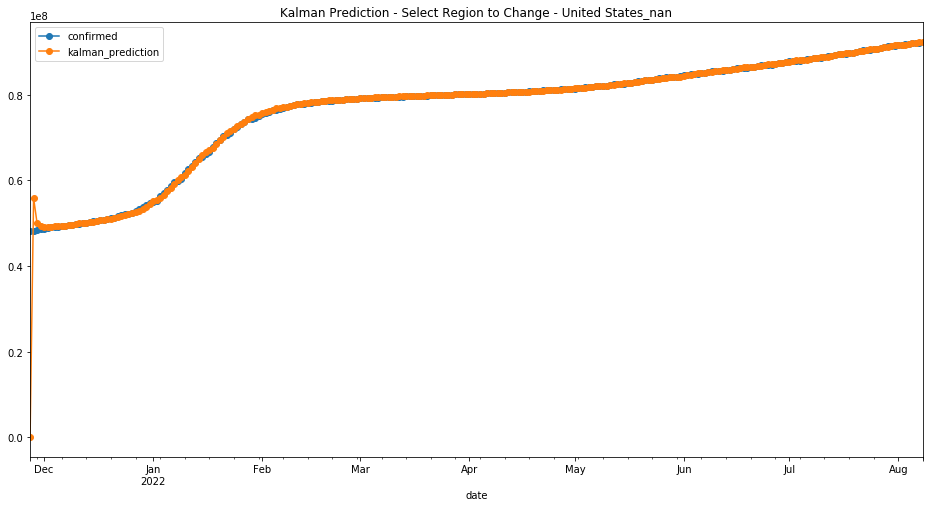

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse           mae
219  Russia_nan  1.349748e+12  1.161787e+06  91843.610236


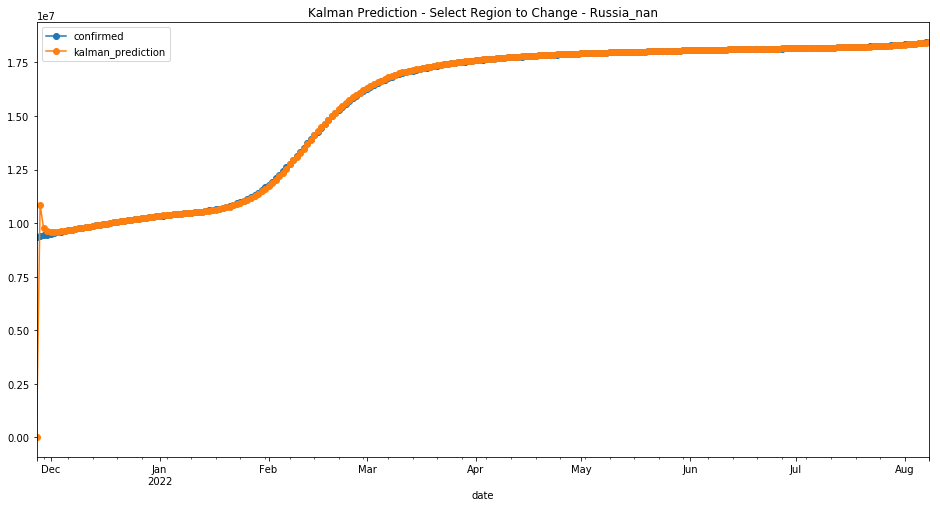

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
31  Brazil_nan  4.620240e+12  2.149474e+06  181622.141732


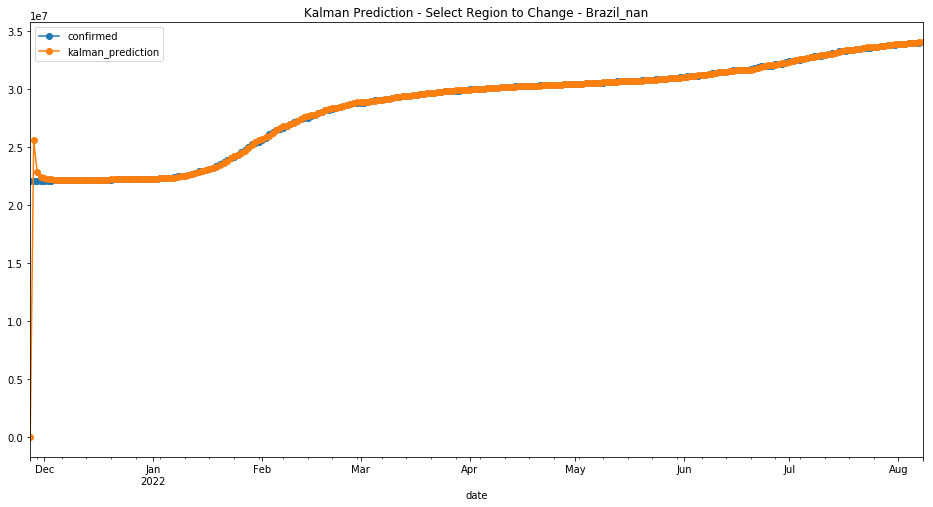

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse            mae
273  United Kingdom_nan  2.168666e+12  1.472639e+06  138398.122047


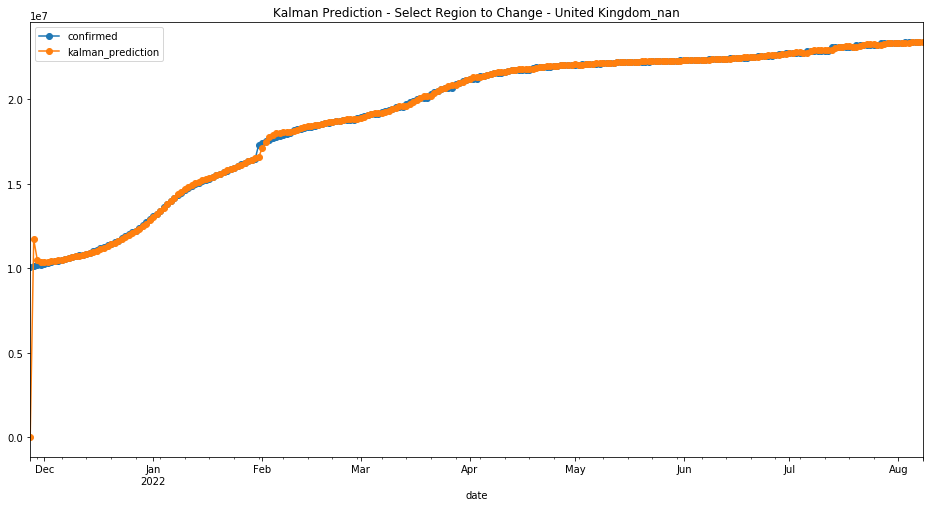

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  ----------------------------------------
H2O cluster uptime:         1 day 5 hours 6 mins
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 9 months and 12 days !!!
H2O cluster name:           H2O_from_python_unknownUser_gw6ijg
H2O cluster total nodes:    1
H2O cluster free memory:    1.688 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-07-27
last_train_date= 2022-08-07
first_bootstrap_date= 2022-07-30
boost_bootstrap_date= 2022-08-04
first_test_date= 2022-07-29
last_test_date= 2022-08-08
first_valid_date= 2022-08-06


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   187859.0     185552 2022-07-30  Afghanistan_nan
1   187932.0     185749 2022-07-31  Afghanistan_nan
2   188035.0     185930 2022-08-01  Afghanistan_nan
3   188206.0     186120 2022-08-02  Afghanistan_nan
4   188396.0     186393 2022-08-03  Afghanistan_nan
5   188624.0     186697 2022-08-04  Afghanistan_nan
6   188918.0     187037 2022-08-05  Afghanistan_nan
7   189260.0     187109 2022-08-06  Afghanistan_nan
8   189514.0     187442 2022-08-07  Afghanistan_nan
9   189731.0          0 2022-08-08  Afghanistan_nan
10  312661.0     311381 2022-07-30      Albania_nan
11  313729.0     312097 2022-07-31      Albania_nan
12  314525.0     312375 2022-08-01      Albania_nan
13  314862.0     313582 2022-08-02      Albania_nan
14  315797.0     314561 2022-08-03      Albania_nan
15  316679.0     315337 2022-08-04      Albania_nan
16  317505.0     316145 2022-08-05      Albania_nan
17  318301.0     316976 2022-08-06      Albania_nan
18  319112.0     317514 2022-08-07      Albania_nan
19  319702.0          0 2022-08-08      Albania_nan
20  269542.0     267374 2022-07-30      Algeria_nan
21  269638.0     267454 2022-07-31      Algeria_nan
22  269724.0     267546 2022-08-01      Algeria_nan
23  269814.0     267657 2022-08-02      Algeria_nan
24  269918.0     267777 2022-08-03      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  4809377.0    4815584 2022-08-04     Austria_nan
176  4820281.0    4821763 2022-08-05     Austria_nan
177  4827378.0    4821763 2022-08-06     Austria_nan
178  4826682.0    4821763 2022-08-07     Austria_nan
179  4826683.0          0 2022-08-08     Austria_nan
180   799929.0     798404 2022-07-30  Azerbaijan_nan
181   800330.0     798838 2022-07-31  Azerbaijan_nan
182   800780.0     798940 2022-08-01  Azerbaijan_nan
183   800875.0     799471 2022-08-02  Azerbaijan_nan
184   801453.0     799983 2022-08-03  Azerbaijan_nan
185   801927.0     800478 2022-08-04  Azerbaijan_nan
186   802436.0     801018 2022-08-05  Azerbaijan_nan
187   803005.0     801470 2022-08-06  Azerbaijan_nan
188   803485.0     801939 2022-08-07  Azerbaijan_nan
189   803994.0          0 2022-08-08  Azerbaijan_nan
190    38386.0      36670 2022-07-30     Bahamas_nan
191    38408.0      36724 2022-07-31     Bahamas_nan
192    38244.0      36730 2022-08-01     Bahamas_nan
193    38444.0      36730 2022-08-02     Bahamas_nan
194    38473.0      36745 2022-08-03     Bahamas_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date        region
220   91808.0      91895 2022-07-30  Barbados_nan
221   92142.0      92086 2022-07-31  Barbados_nan
222   92481.0      92301 2022-08-01  Barbados_nan
223   92635.0      92516 2022-08-02  Barbados_nan
224   92814.0      92841 2022-08-03  Barbados_nan
225   92957.0      93559 2022-08-04  Barbados_nan
226   93104.0      94093 2022-08-05  Barbados_nan
227   93928.0      94601 2022-08-06  Barbados_nan
228   94560.0      94963 2022-08-07  Barbados_nan
229   95155.0          0 2022-08-08  Barbados_nan
230  995494.0     994037 2022-07-30   Belarus_nan
231  995493.0     994037 2022-07-31   Belarus_nan
232  995492.0     994037 2022-08-01   Belarus_nan
233  995490.0     994037 2022-08-02   Belarus_nan
234  995489.0     994037 2022-08-03   Belarus_nan
235  995489.0     994037 2022-08-04   Belarus_nan
236  995489.0     994037 2022-08-05   Belarus_nan
237  995489.0     994037 2022-08-06   Belarus_nan
238  995489.0     994037 2022-08-07   Belarus_nan
239  995489.0          0 2022-08-08   Belarus_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  246034153620.42395
# MSE on the validation data =  146095081967394.9
# R^2 on the training data =  0.9989063268854012
# R^2 on the validation data =  0.3746324964281693


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1659834957504_9


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 246034153620.42395
RMSE: 496018.2996830096
MAE: 36326.44528323582
RMSLE: 0.41167384438175836
Mean Residual Deviance: 246034153620.42395

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 146095081967394.9
RMSE: 12086979.853023455
MAE: 3970501.7306799707
RMSLE: 8.726162415654402
Mean Residual Deviance: 146095081967394.9
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2022-08-08 06:22:19  0.007 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2022-08-08 06:22:19  0.072 sec   1.0                393406.55397665297  56473.72583892681   154768716711.7852    12176676.42442671   3979349.943737683   148271448745189.25
     2022-08-08 06:22:19  0.120 sec   2.0                346830.7335894185   60185.439119635776  120291557762.17422   12181770.641246676  3981041.7578960797  148395535955939.47
     2022-08-08 06:22:19  0.165 sec   3.0                398351.8151410101   77700.80136903838   158684168626.13748   11962660.69942695   3980647.648352454   143105251009614.12
     2022-08-08 06:22:20  0.218 sec   4.0                748027.4168674127   81923.47610975428   559545016385.3341    12015535.299894556  3980114.2137946053  144373088543012.16
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2022-08-08 06:22:31  11.989 sec  228.0              512277.09809296316  39289.96396928974   262427825230.5474    12086459.617305651  3970072.6314383135  146082506080760.25
     2022-08-08 06:22:35  15.998 sec  311.0              503213.13366544584  37679.579768115895  253223457893.3979    12089981.578096762  3970534.1740327463  146167654558719.1
     2022-08-08 06:22:39  20.050 sec  392.0              503299.58969023643  36888.79526114731   253310476982.36032   12085689.864879785  3970684.031674426   146063899510057.94
     2022-08-08 06:22:43  24.058 sec  472.0              495533.2633653984   36499.41086828001   245553215101.56128   12087467.710748818  3970994.679102069   146106875658395.25
     2022-08-08 06:22:45  25.731 sec  500.0              496018.2996830096   36326.44528323582   246034153620.42395   12086979.853023455  3970501.7306799707  146095081967394.9


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  3.52555e+20            1                    0.383583
last_day           2.90001e+20            0.822569             0.315523
region             1.71111e+20            0.485345             0.18617
7_day_change       3.78263e+19            0.107292             0.0411554
3_day_change       2.78393e+19            0.0789644            0.0302894
infected_rate      1.72571e+19            0.0489487            0.0187759
1_day_change       1.06364e+19            0.0301695            0.0115725
7_day_change_rate  5.164e+18              0.0146474            0.00561847
3_day_change_rate  4.54343e+18            0.0128872            0.00494329
1_day_change_rate  2.17755e+18            0.00617649           0.0023692

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         3.525550e+20           1.000000    0.383583
1           last_day         2.900007e+20           0.822569    0.315523
2             region         1.711109e+20           0.485345    0.186170
3       7_day_change         3.782634e+19           0.107292    0.041155
4       3_day_change         2.783929e+19           0.078964    0.030289
5      infected_rate         1.725710e+19           0.048949    0.018776
6       1_day_change         1.063639e+19           0.030169    0.011572
7  7_day_change_rate         5.163998e+18           0.014647    0.005618
8  3_day_change_rate         4.543431e+18           0.012887    0.004943
9  1_day_change_rate         2.177554e+18           0.006176    0.002369

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


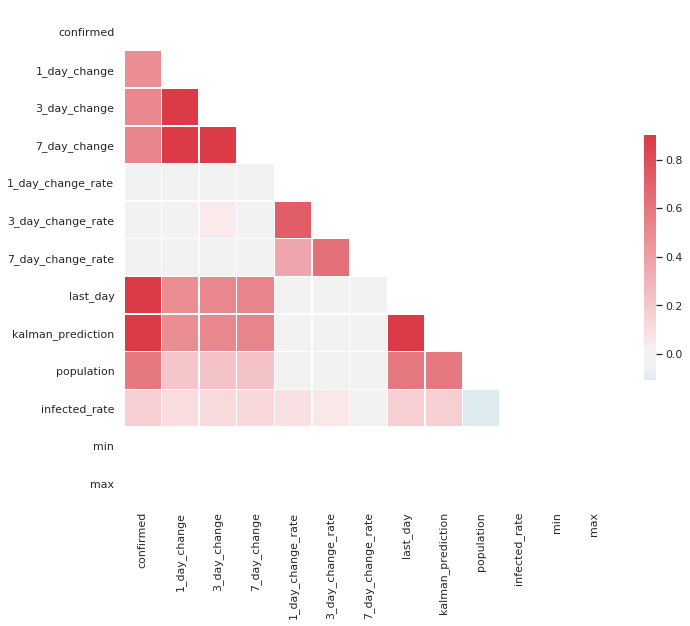

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.490195
3_day_change         0.522668
7_day_change         0.539441
1_day_change_rate    0.017954
3_day_change_rate    0.008633
7_day_change_rate   -0.002654
last_day             0.995231
kalman_prediction    0.996062
population           0.594325
infected_rate        0.169229
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


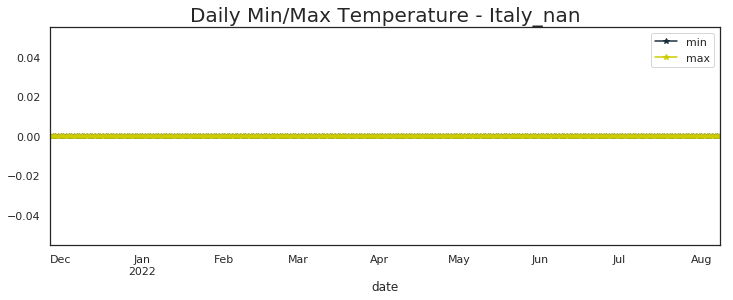

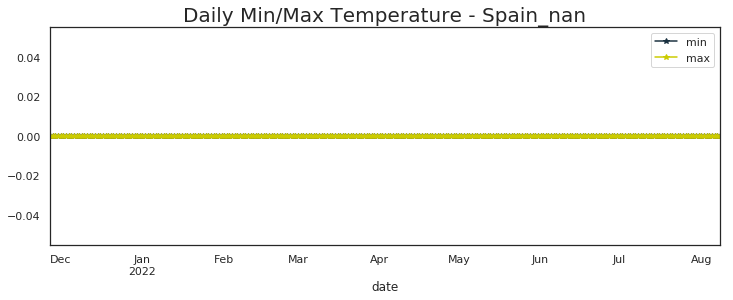

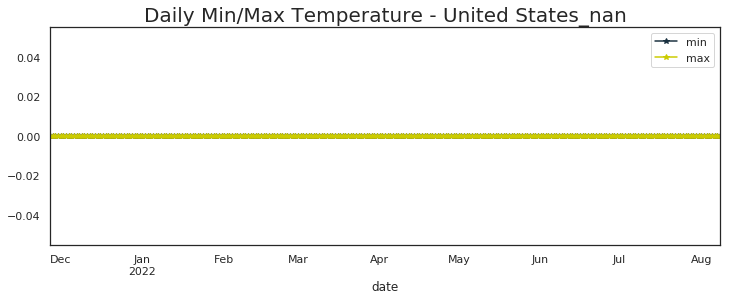

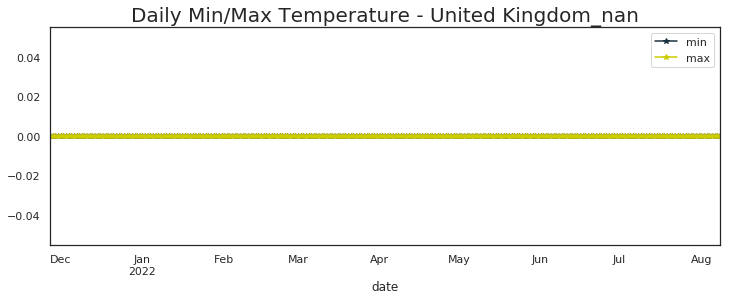

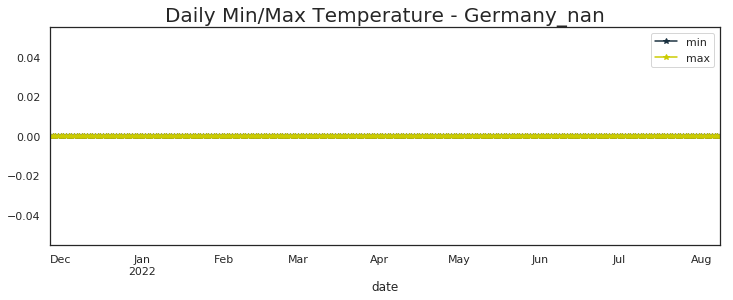

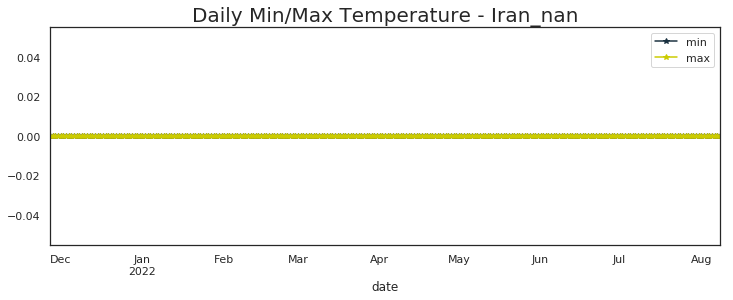

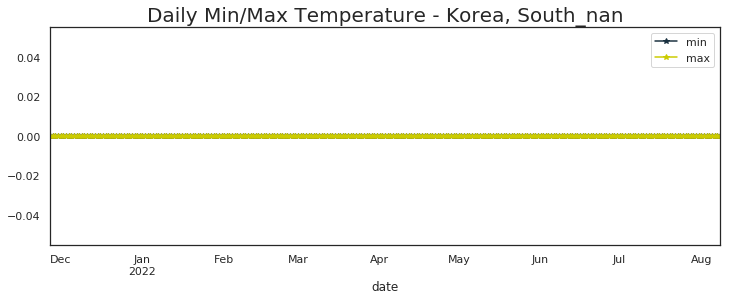

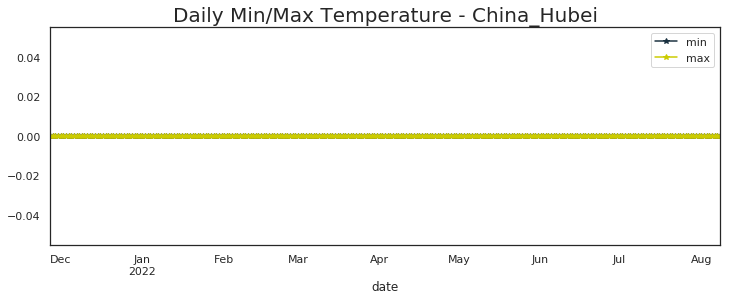

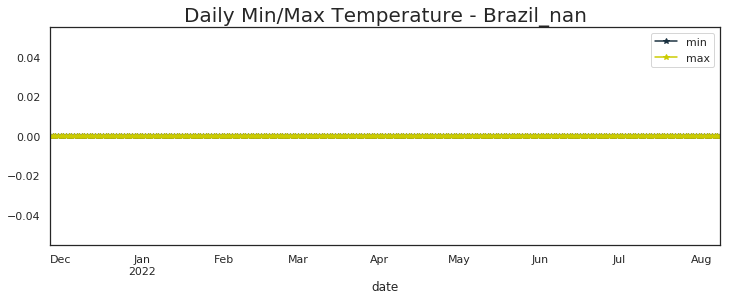

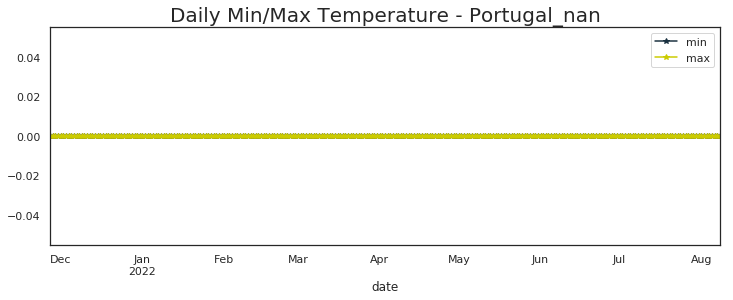

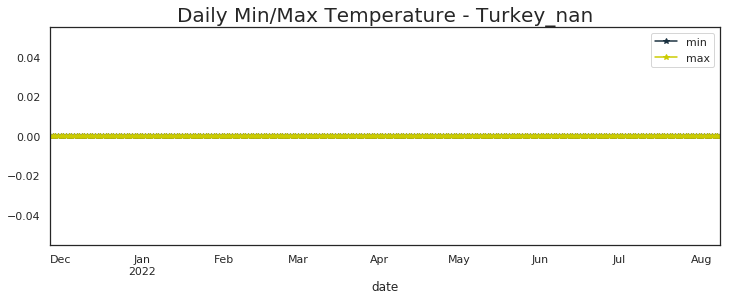

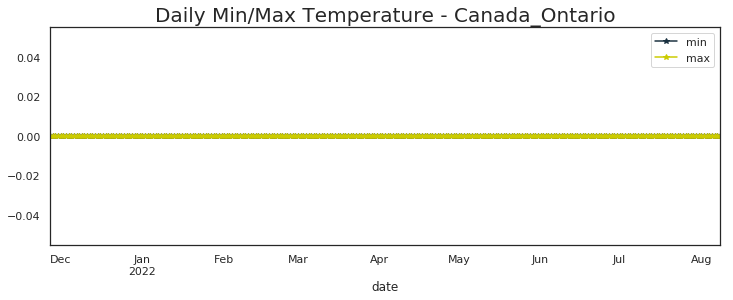

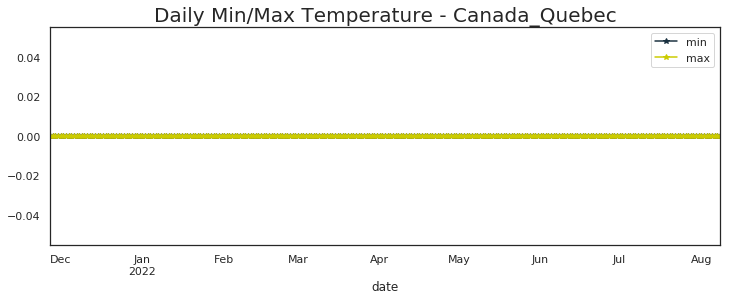

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                           min  max
region                             
United States_nan          0.0  0.0
India_nan                  0.0  0.0
Brazil_nan                 0.0  0.0
France_nan                 0.0  0.0
Germany_nan                0.0  0.0
United Kingdom_nan         0.0  0.0
Italy_nan                  0.0  0.0
Korea, South_nan           0.0  0.0
Russia_nan                 0.0  0.0
Turkey_nan                 0.0  0.0
Japan_nan                  0.0  0.0
Spain_nan                  0.0  0.0
Vietnam_nan                0.0  0.0
Argentina_nan              0.0  0.0
Netherlands_nan            0.0  0.0
Iran_nan                   0.0  0.0
Mexico_nan                 0.0  0.0
Colombia_nan               0.0  0.0
Indonesia_nan              0.0  0.0
Poland_nan                 0.0  0.0
Portugal_nan               0.0  0.0
Ukraine_nan                0.0  0.0
Austria_nan                0.0  0.0
Taiwan*_nan                0.0  0.0
Malaysia_nan               0

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

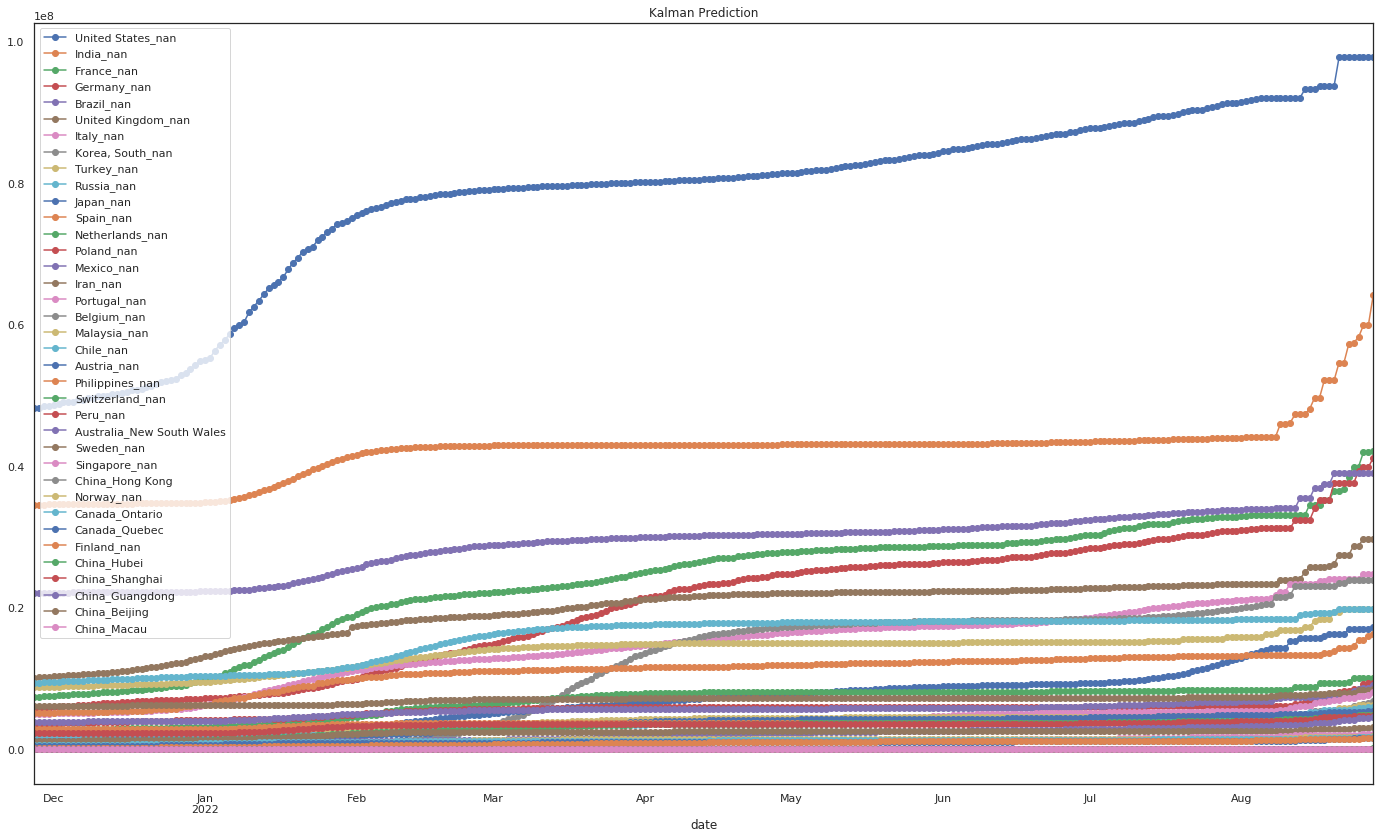

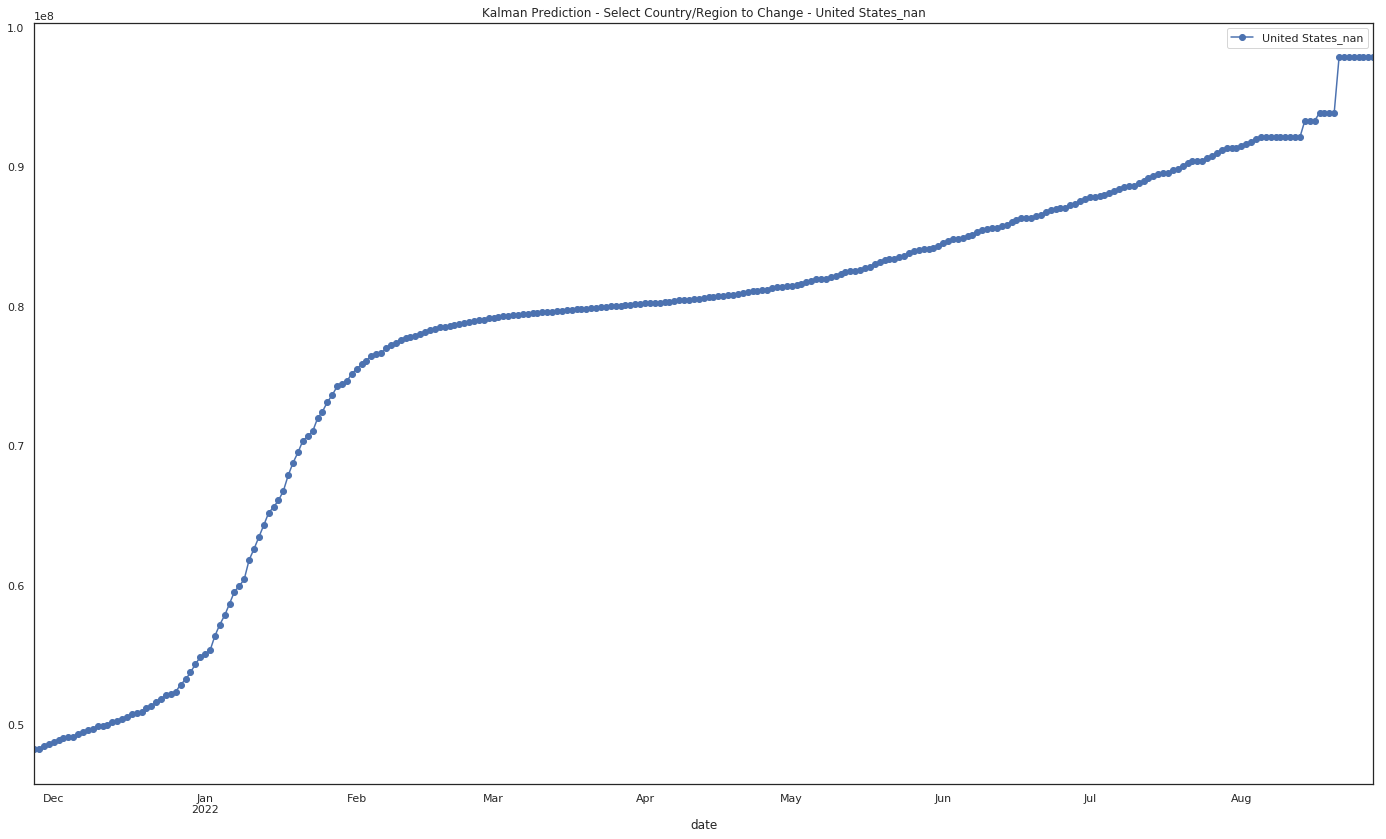

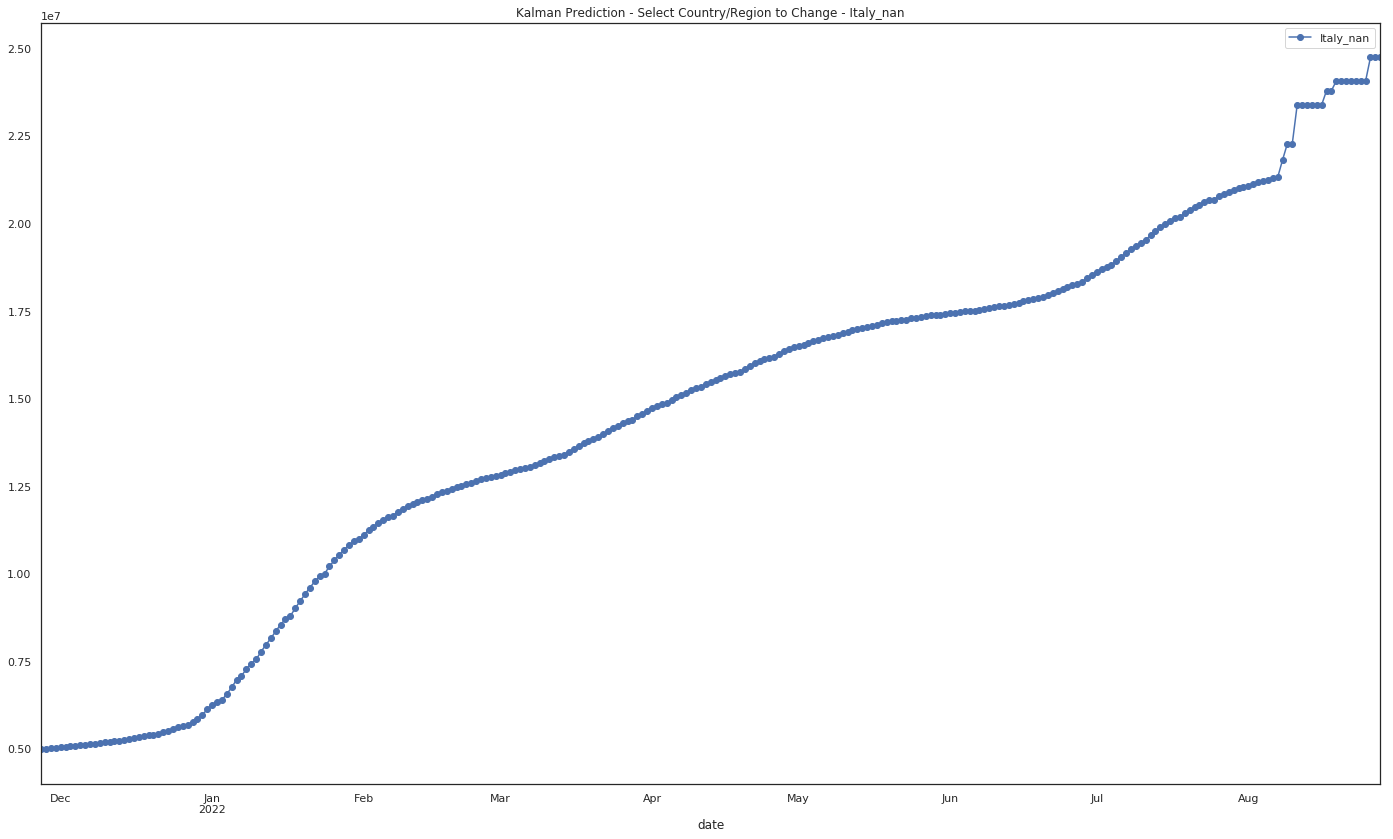

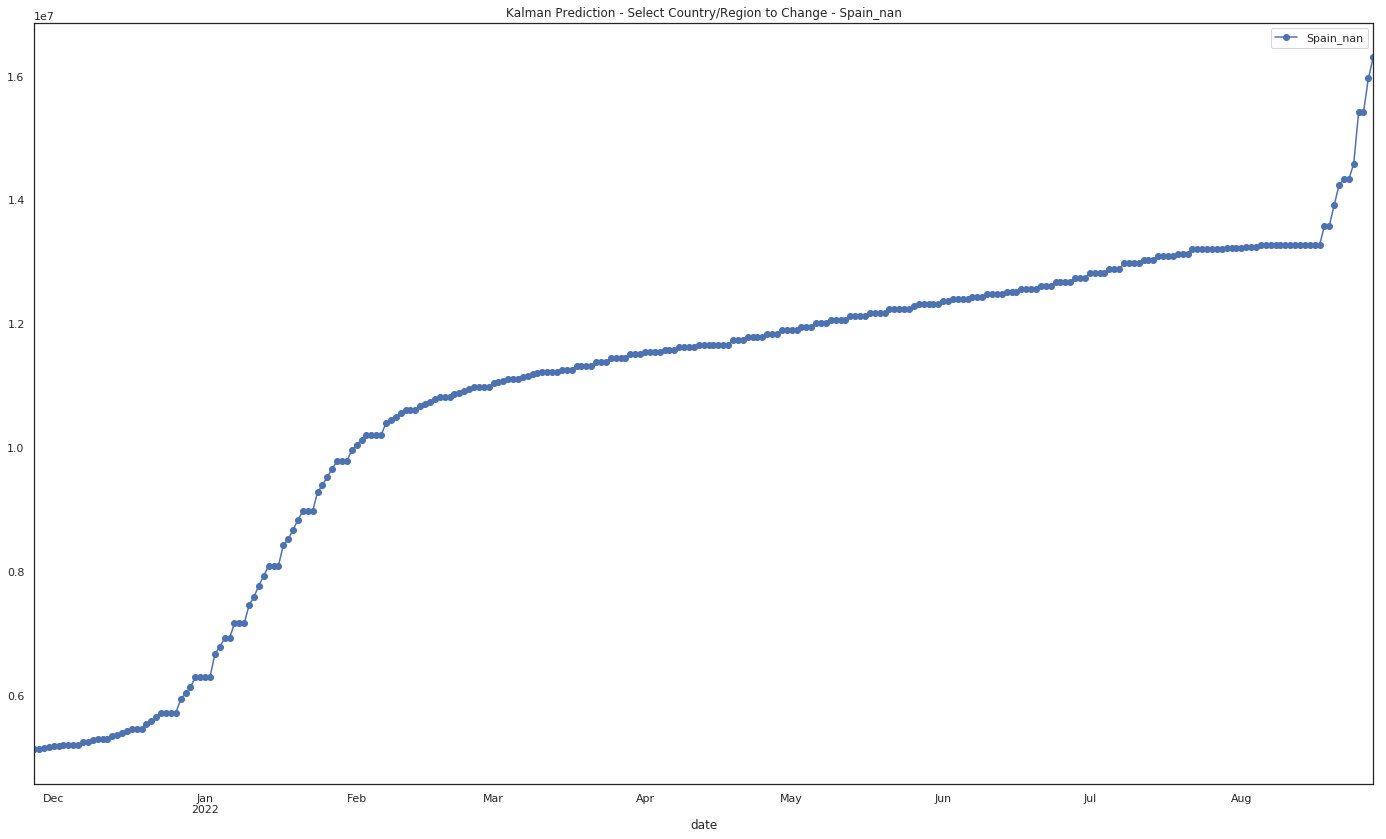

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


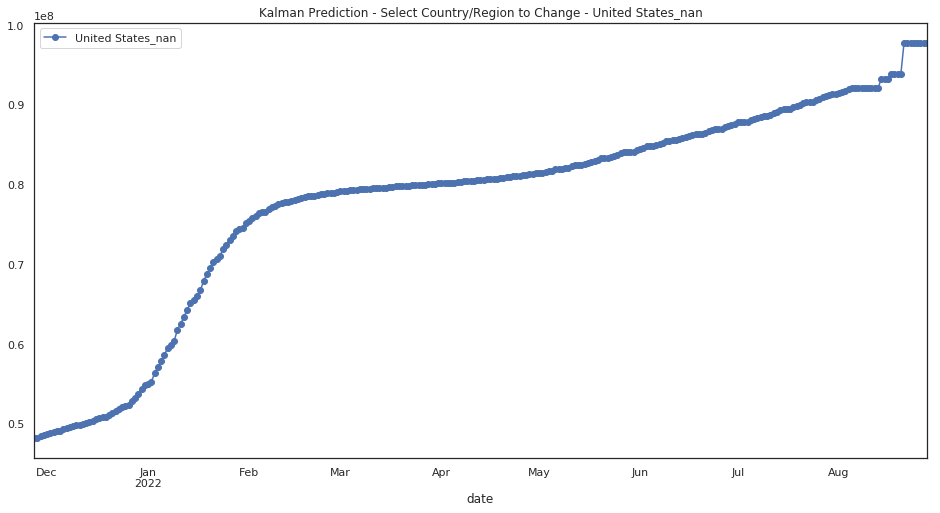

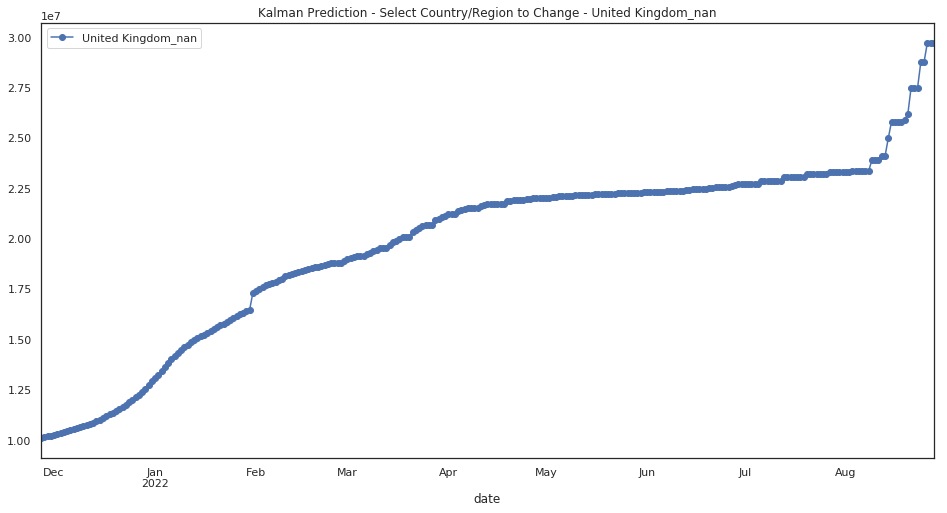

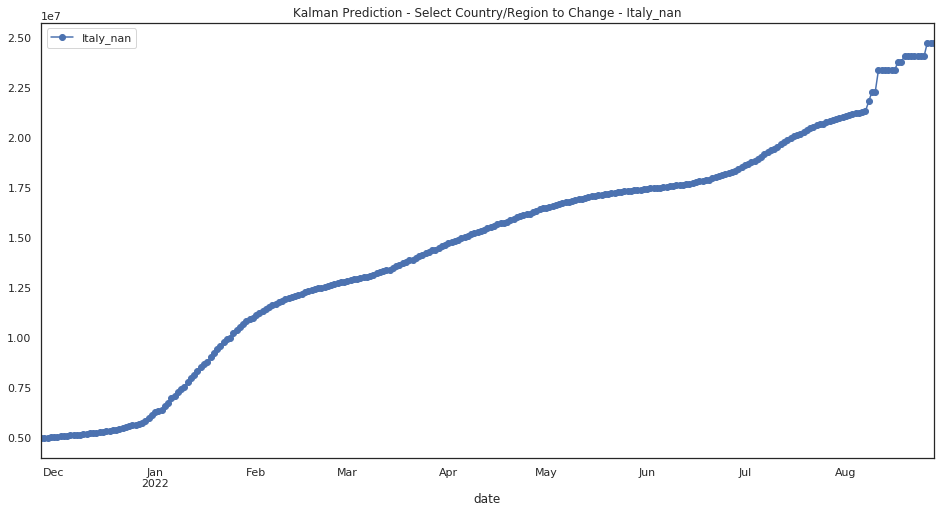

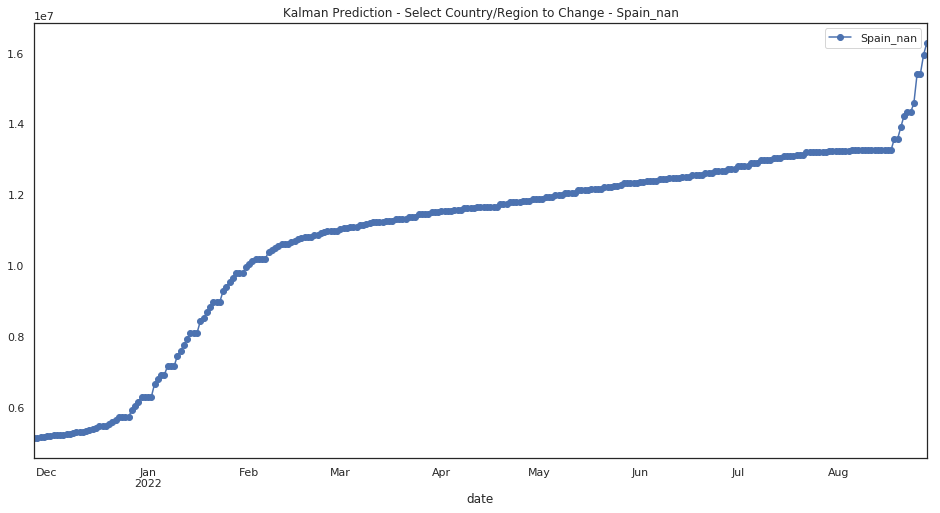

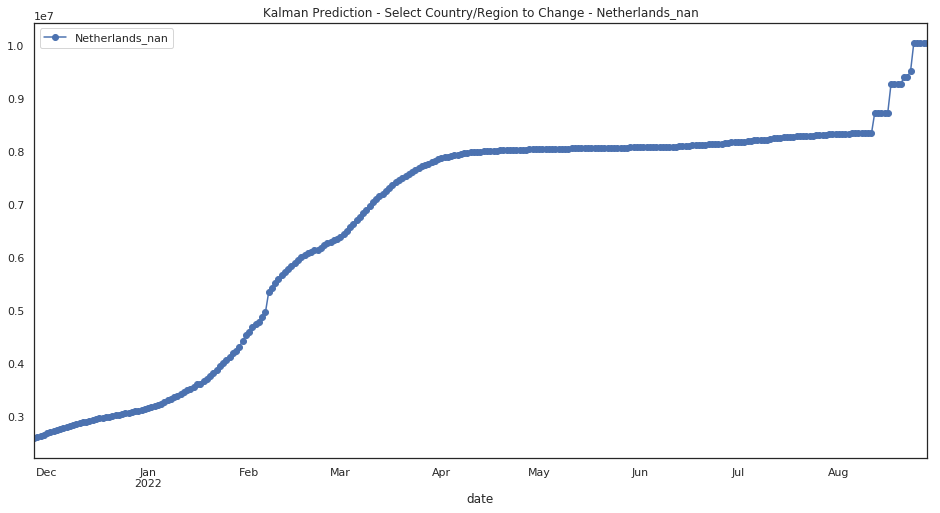

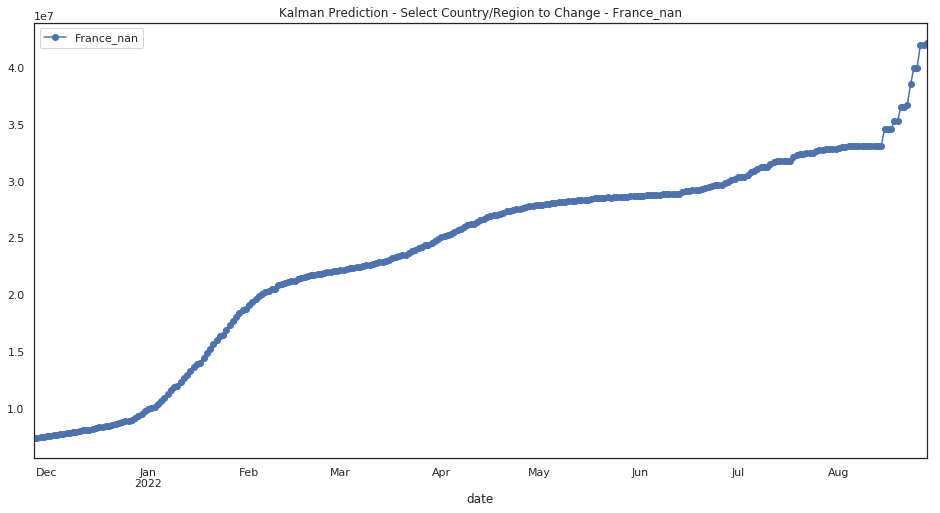

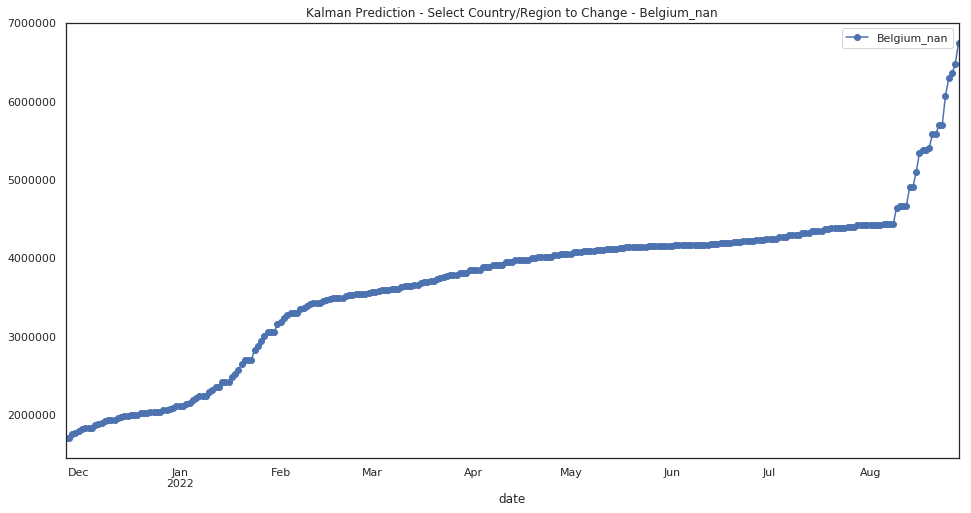

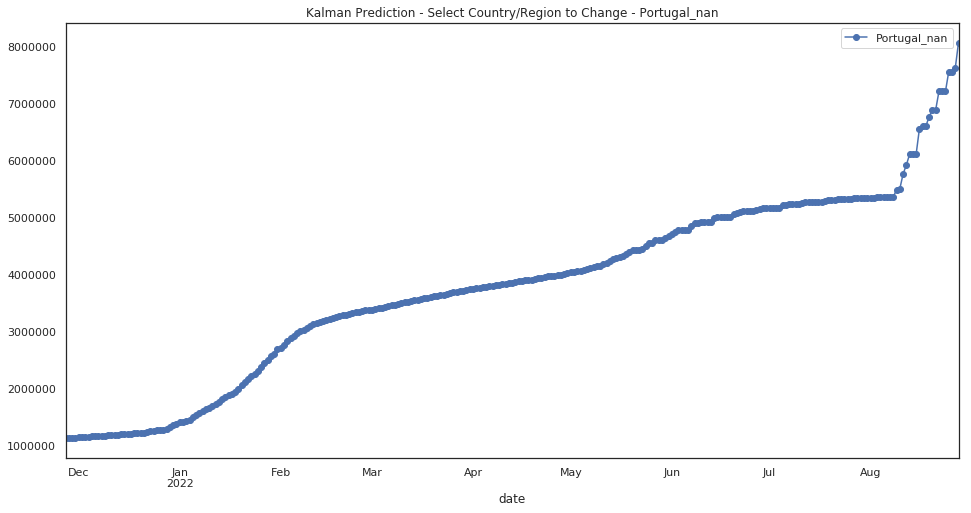

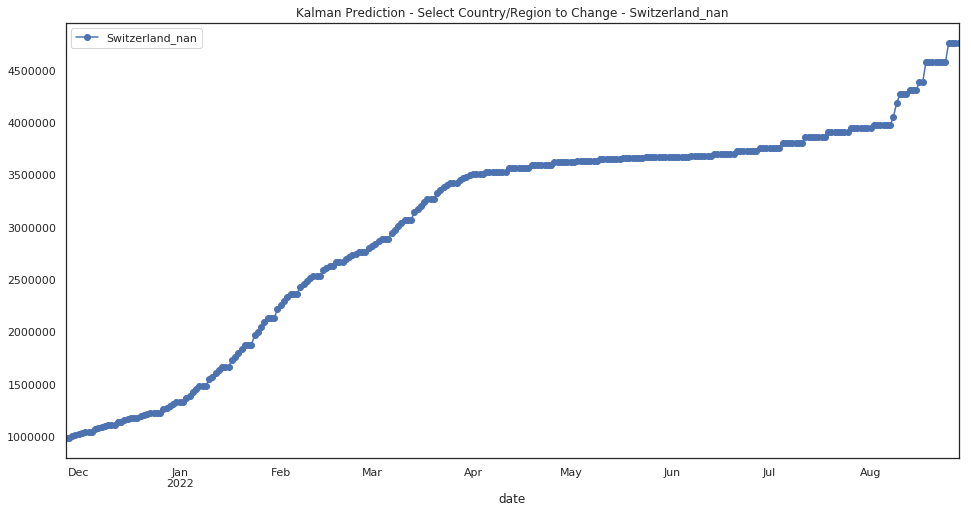

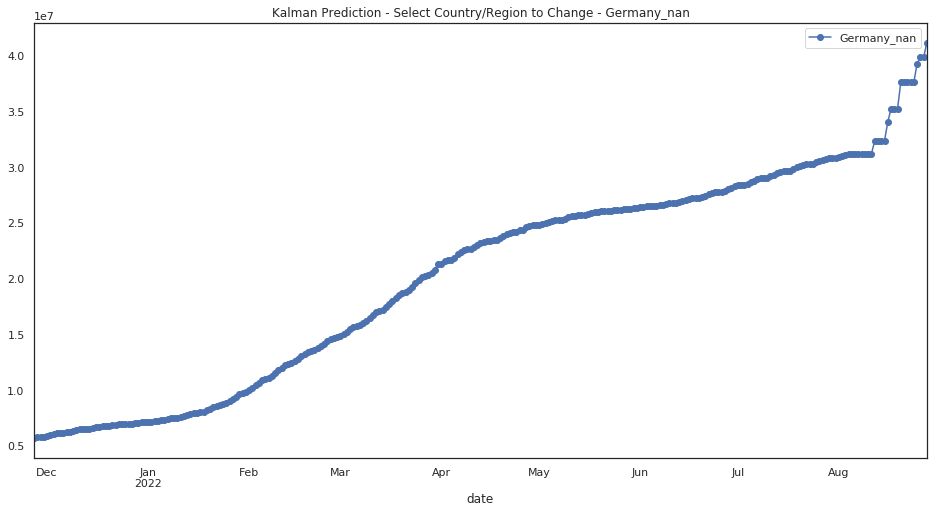

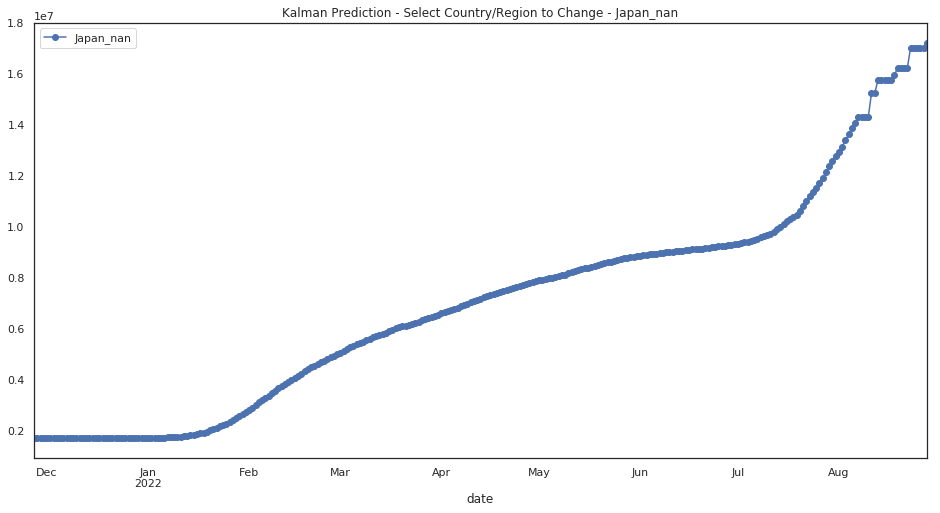

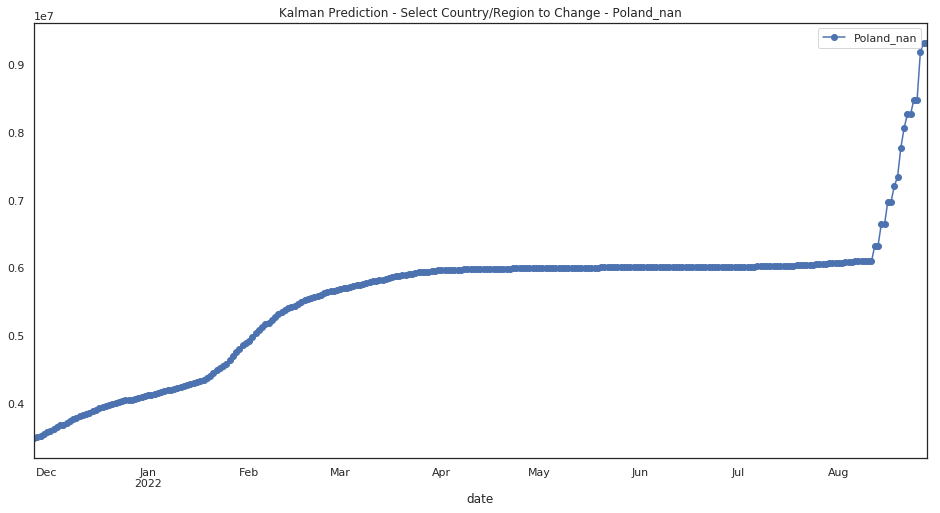

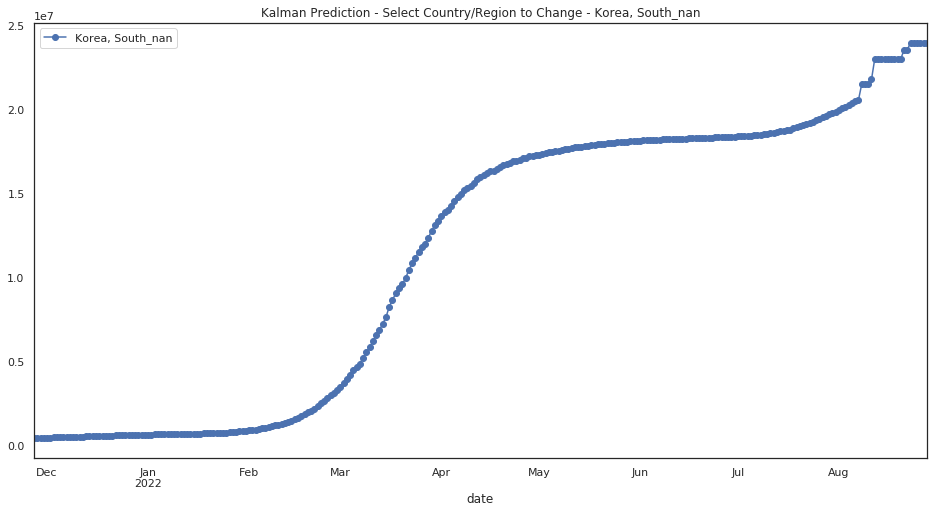

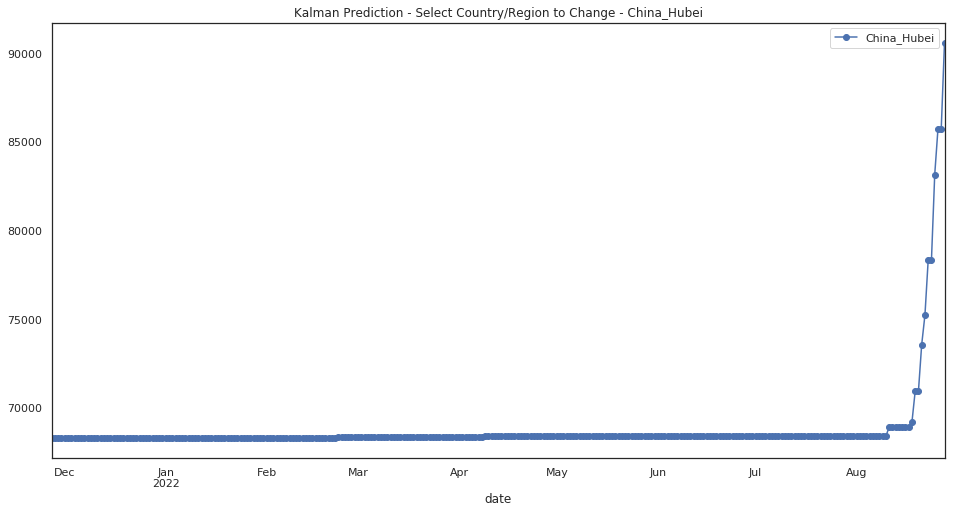

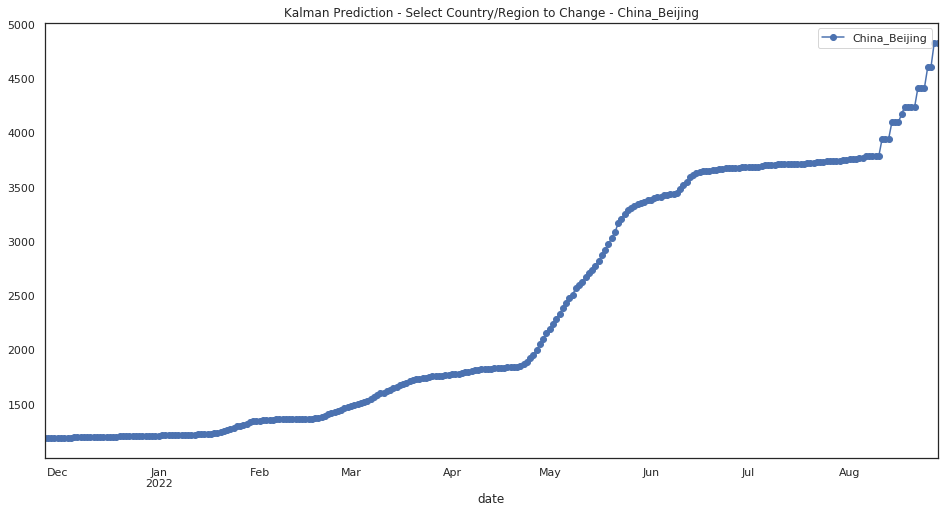

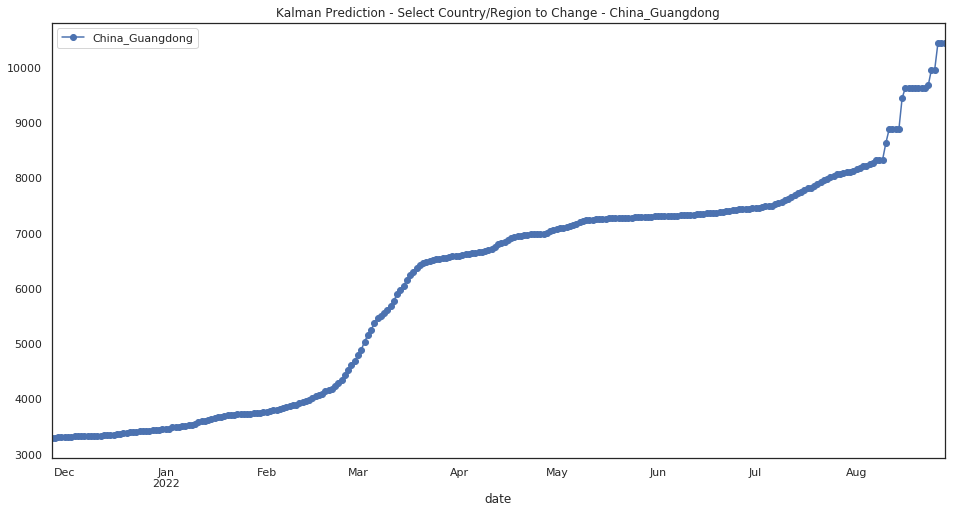

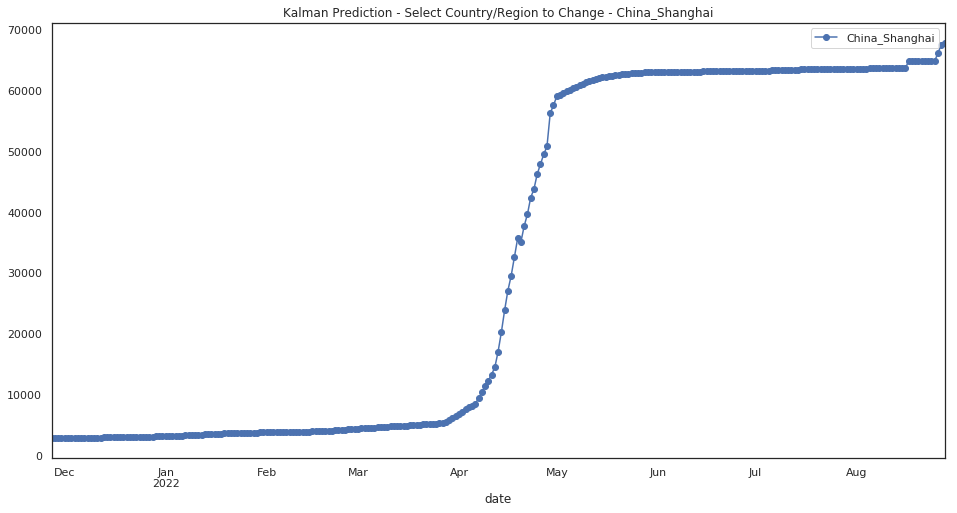

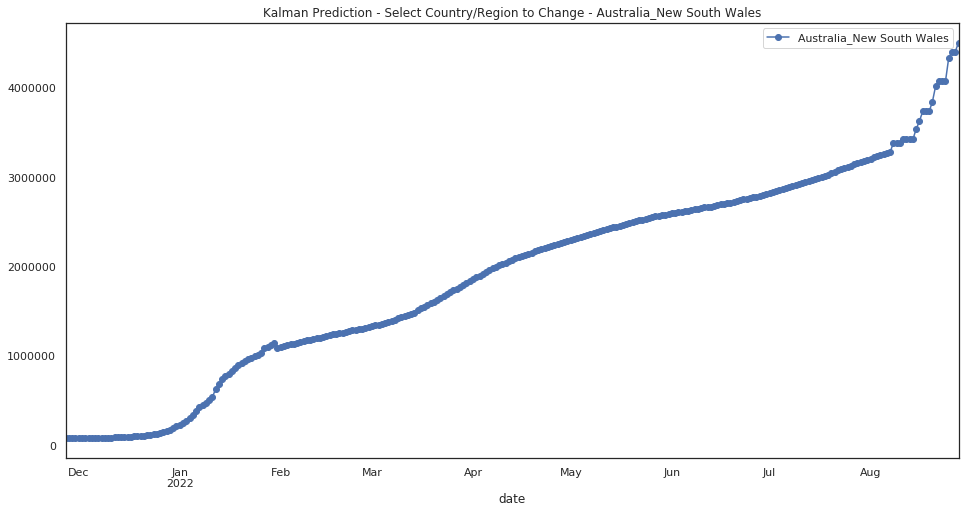

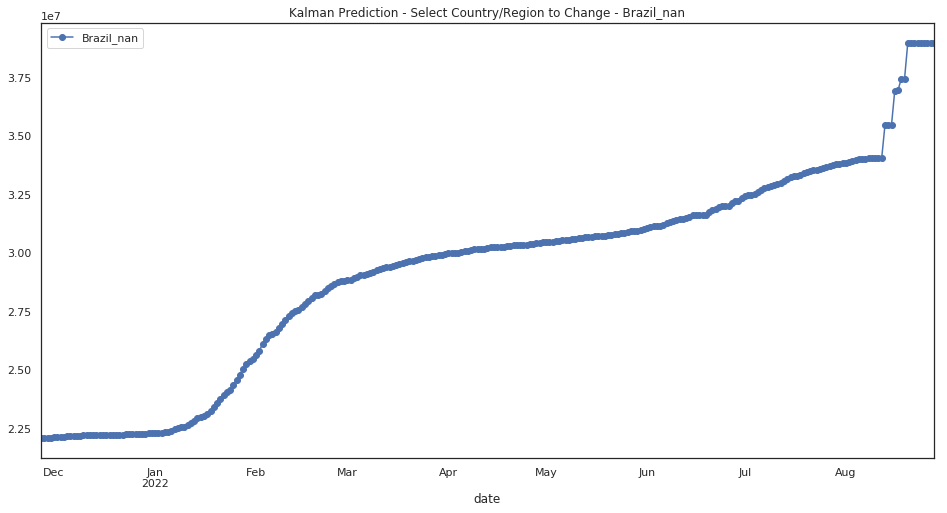

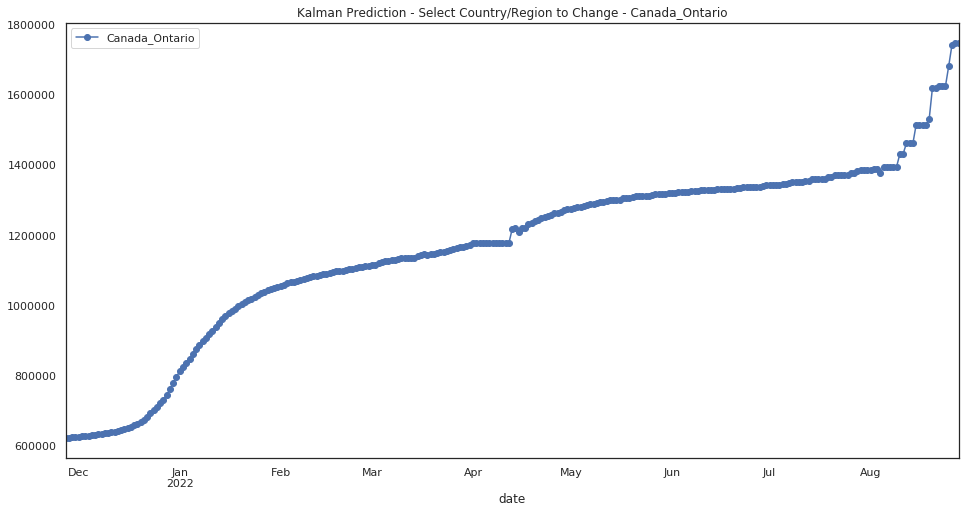

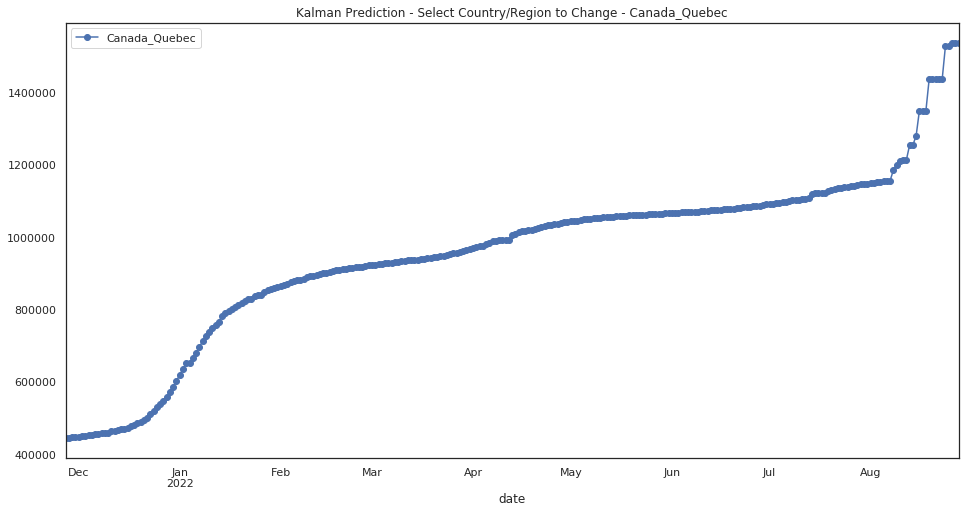

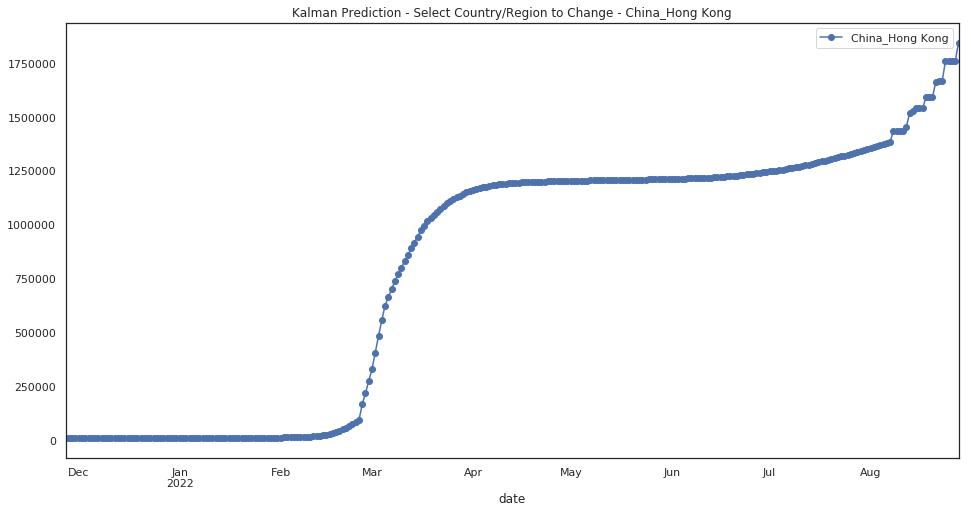

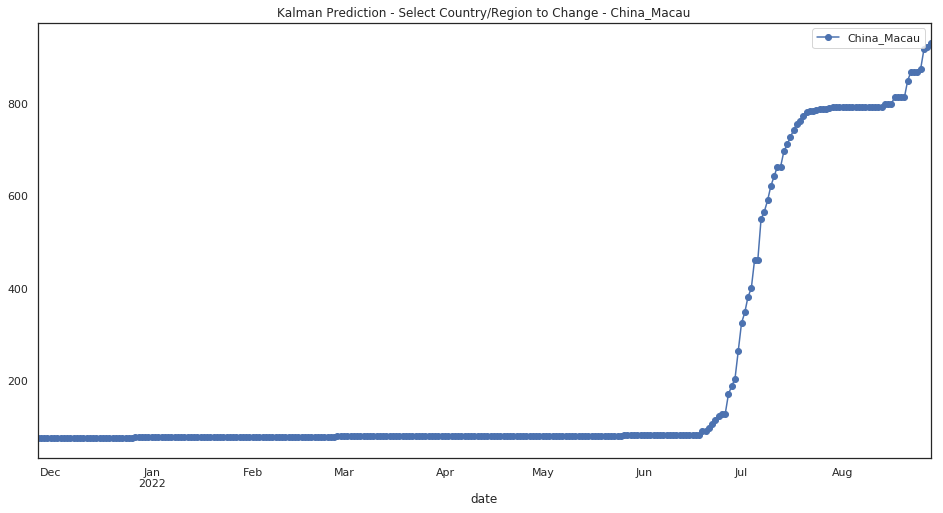

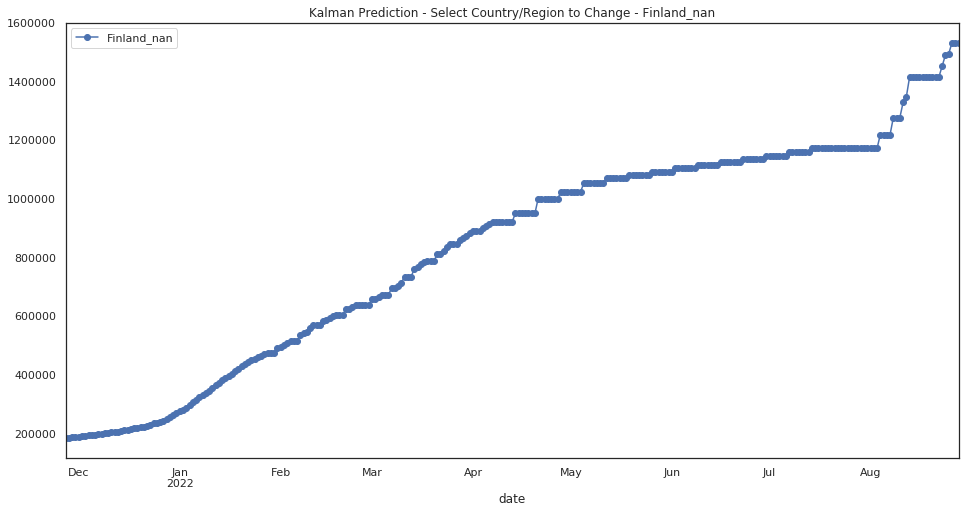

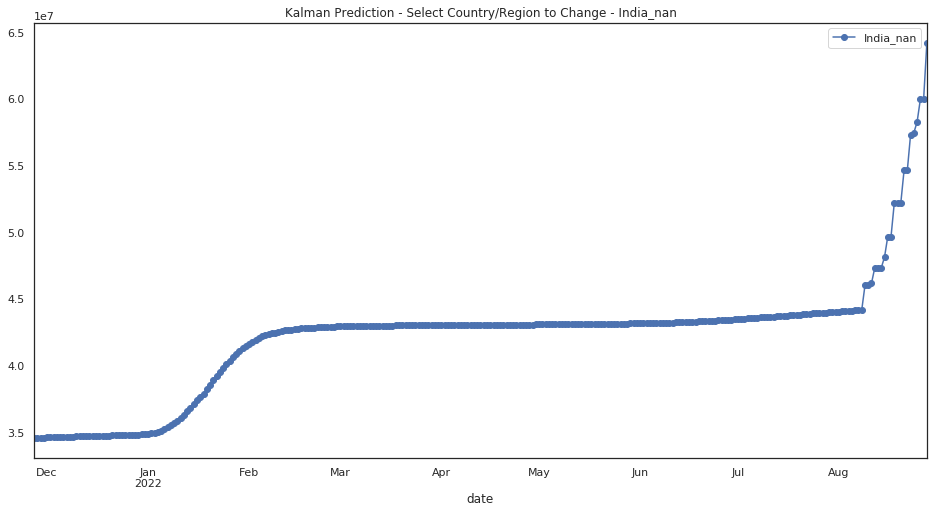

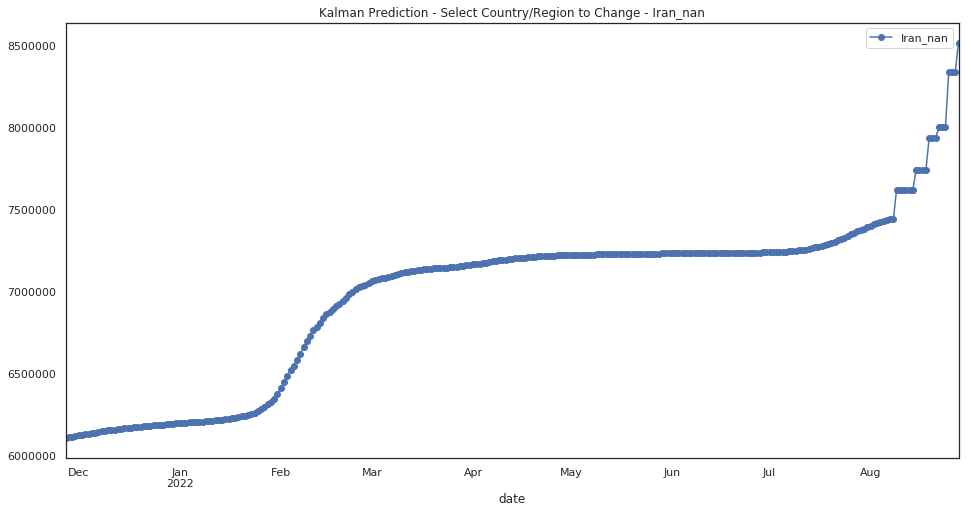

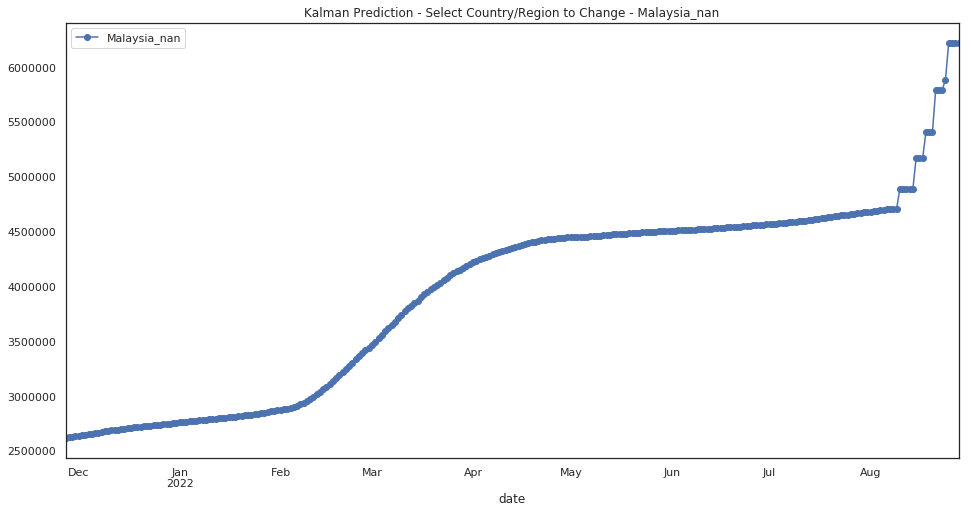

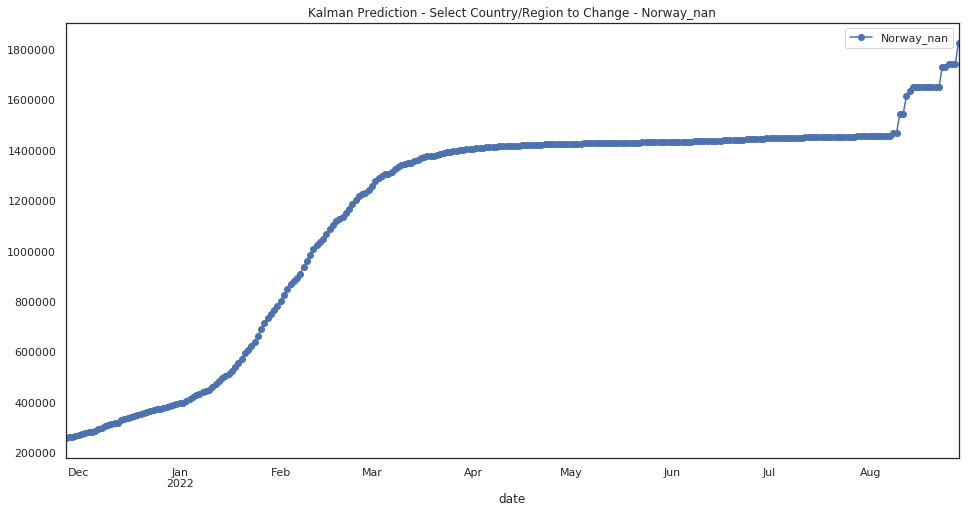

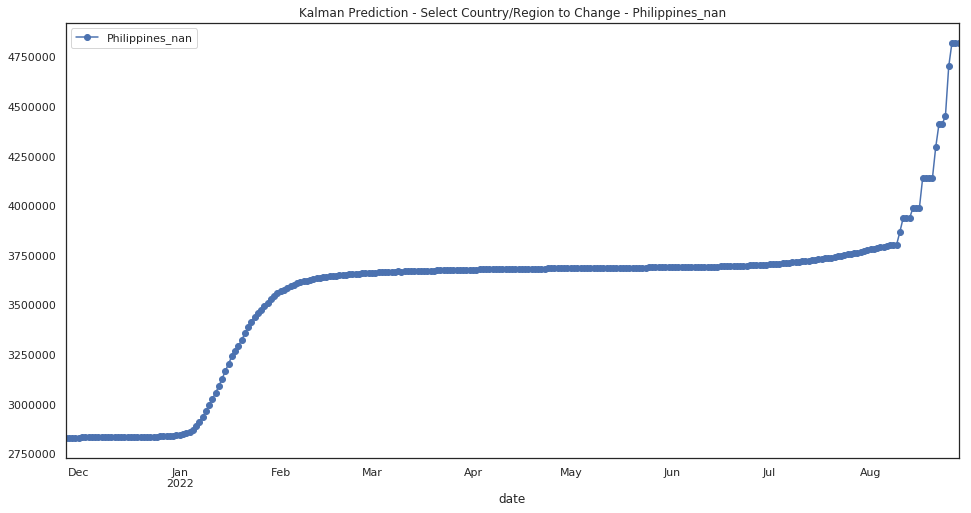

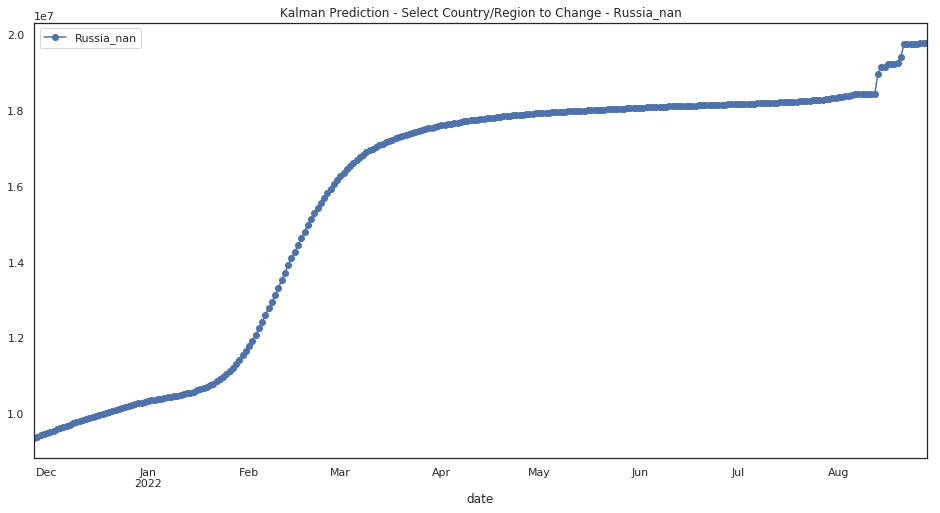

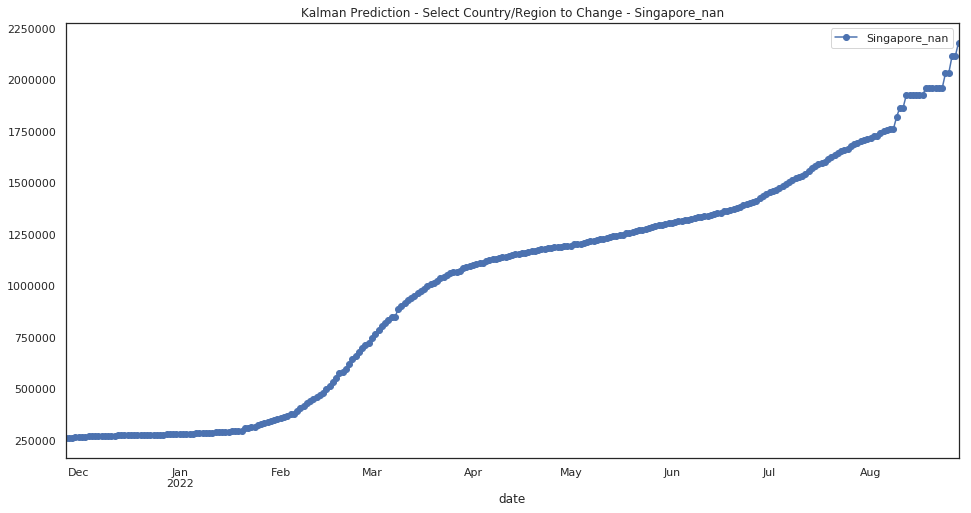

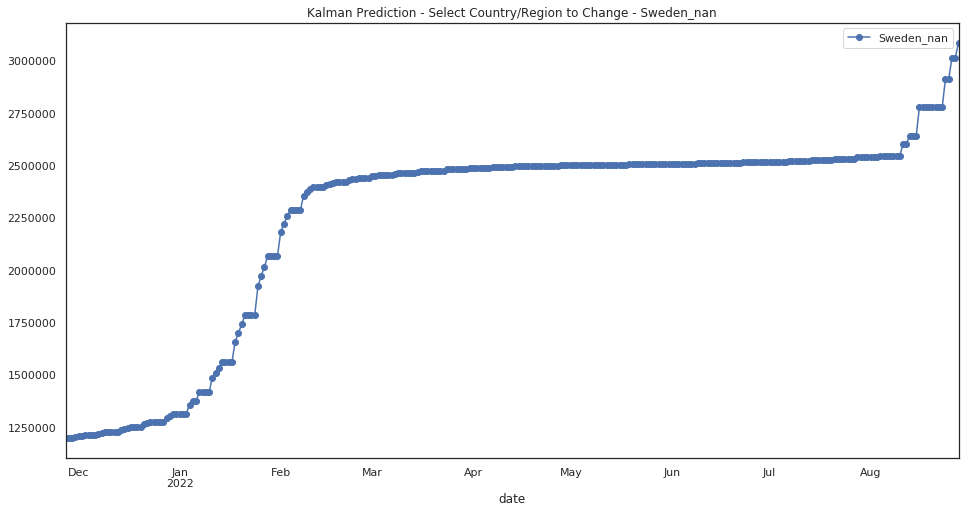

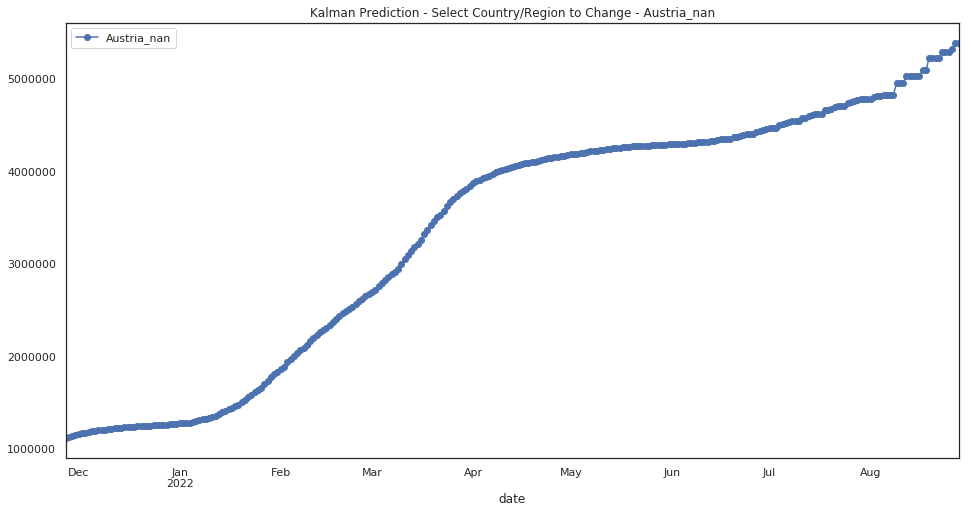

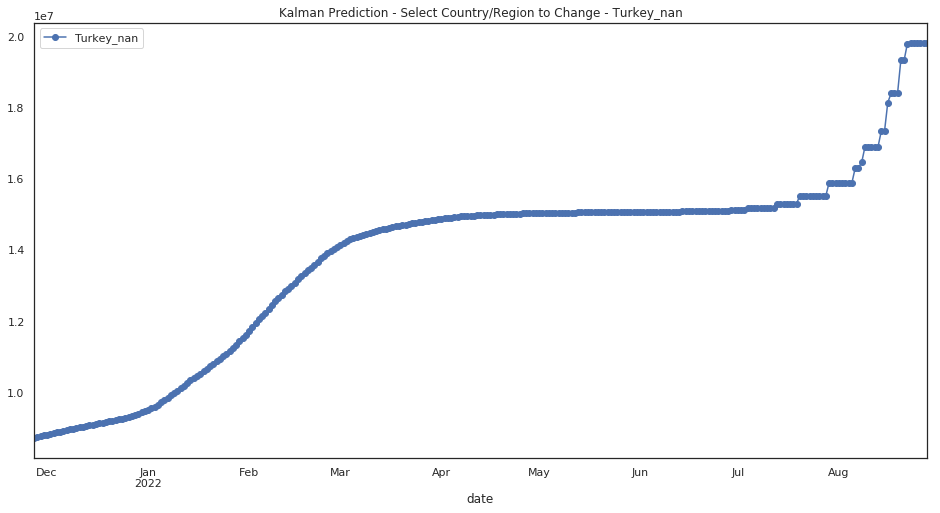

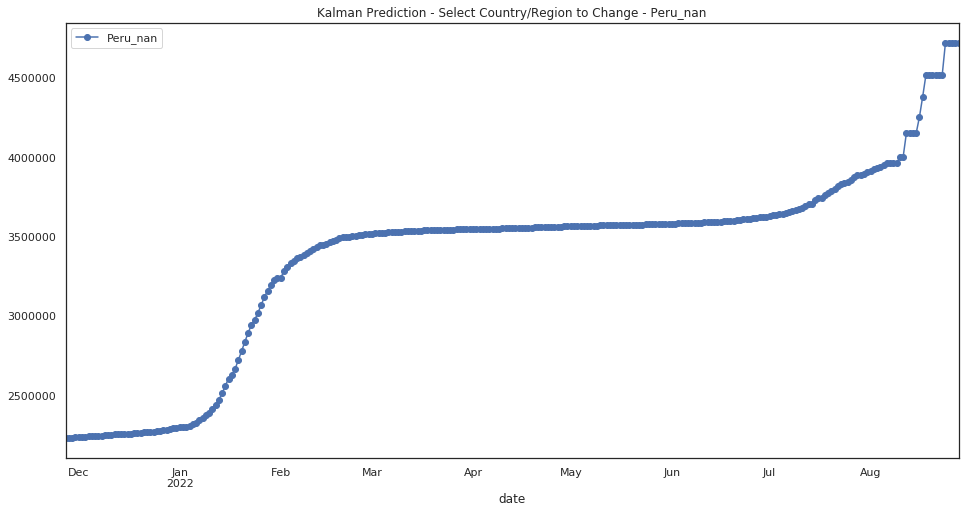

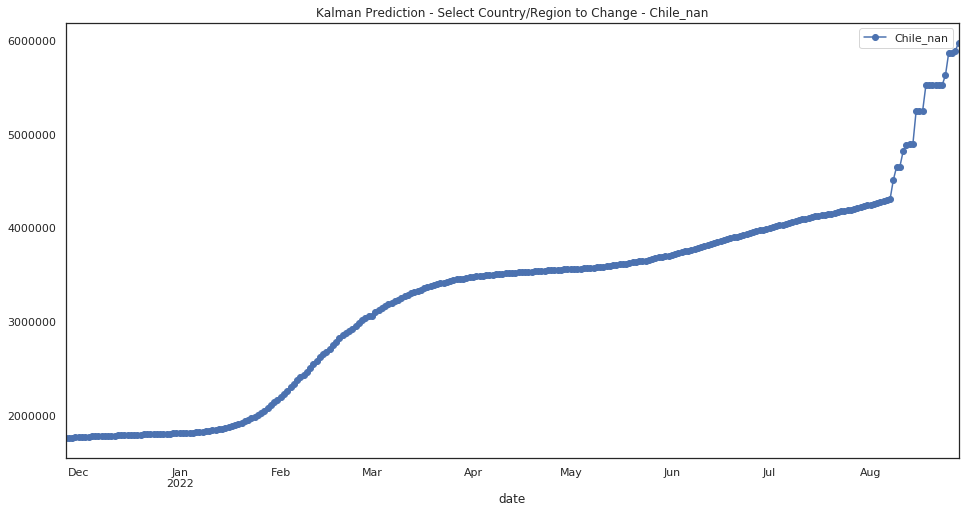

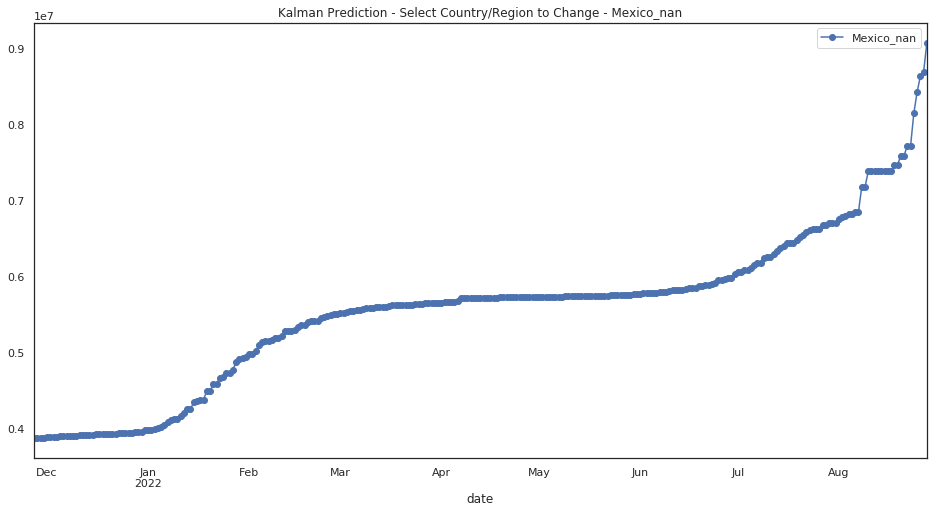

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-08-28 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN      97834704.0
India_nan                                           NaN      64220207.0
France_nan                                          NaN      42210146.0
Germany_nan                                         NaN      41193900.0
Brazil_nan                                          NaN      38996392.0
United Kingdom_nan                                  NaN      29737766.0
Italy_nan                                           NaN      24745951.0
Korea, South_nan                                    NaN      23967353.0
Turkey_nan                                          NaN      19820049.0
Russia_nan                                          NaN      19784917.0
Japan_nan                                           NaN      17212506.0
Spain_nan                                           NaN      16303833.0
Vietnam_nan                                         NaN      15079341.0
Argentina_nan                                       NaN      11314968.0
Netherlands_nan                                     NaN      10063848.0
Poland_nan                                          NaN       9327070.0
Mexico_nan                                          NaN       9084509.0
Iran_nan                                            NaN       8519555.0
Colombia_nan                                        NaN       8099383.0
Portugal_nan                                        NaN       8062200.0
Indonesia_nan                                       NaN       7777620.0
Taiwan*_nan                                         NaN       6891407.0
Ukraine_nan                                         NaN       6842987.0
Belgium_nan                                         NaN       6749632.0
Malaysia_nan                                        NaN       6223887.0
Israel_nan                                          NaN       6057324.0
Chile_nan                                           NaN       5978875.0
Greece_nan                                          NaN       5605512.0
Thailand_nan                                        NaN       5555666.0
Austria_nan                                         NaN       5388721.0
...                                                 ...             ...
China_Jiangsu                                       NaN          2406.0
United Kingdom_Falkland Islands (Malvinas)          NaN          2395.0
China_Hainan                                        NaN          2023.0
China_Jiangxi                                       NaN          1605.0
China_Anhui                                         NaN          1604.0
China_Hunan                                         NaN          1602.0
China_Gansu                                         NaN          1598.0
Summer Olympics 2020_nan                            NaN          1233.0
China_Xinjiang                                      NaN          1187.0
United Kingdom_Montserrat                           NaN          1153.0
Diamond Princess_nan                                NaN           984.0
China_Chongqing                                     NaN           940.0
France_Wallis and Futuna                            NaN           936.0
China_Macau                                         NaN           931.0
China_Shanxi                                        NaN           695.0
Winter Olympics 2022_nan                            NaN           589.0
China_Qinghai                                       NaN           219.0
China_Guizhou                                       NaN           214.0
China_Ningxia                                       NaN           152.0
Marshall Islands_nan                                NaN            83.0
Holy See_nan                                        NaN            37.0
Canada_Repatriated Travellers                       NaN            19.0
Canada_Grand Princess                               NaN            15.0
Antarctica_nan                                      NaN            11.0
MS Zaandam_nan        

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-11-27         284152.0     320026.0     329299.0     164012.0   
2021-11-28         284176.0     320384.0     329446.0     164012.0   
2021-11-29         157218.0     199555.0     210152.0      16712.0   
2021-11-30         157260.0     199750.0     210344.0      16712.0   
2021-12-01         157289.0     199945.0     210531.0      17115.0   
2021-12-02         157359.0     200173.0     210723.0      17426.0   
2021-12-03         157387.0     200639.0     210921.0      17658.0   
2021-12-04         157412.0     201045.0     211112.0      18010.0   
2021-12-05         159684.0     203388.0     213611.0      19330.0   
2021-12-06         159724.0     203585.0     213802.0      19715.0   
2021-12-07         159730.0     203964.0     213995.0      18631.0   
2021-12-08         159776.0     204265.0     214184.0      18815.0   
2021-12-09         159809.0     204509.0     214365.0      20579.0   
2021-12-10         159826.0     204881.0     214572.0      19272.0   
2021-12-11         159847.0     205171.0     214783.0      19440.0   
2021-12-12         159870.0     205448.0     214981.0      20635.0   
2021-12-13         159879.0     205618.0     215193.0      20371.0   
2021-12-14         159895.0     205973.0     215417.0      20806.0   
2021-12-15         159903.0     206265.0     215655.0      20136.0   
2021-12-16         159958.0     206583.0     215870.0      21634.0   
2021-12-17         159954.0     206889.0     216159.0      20549.0   
2021-12-18         159986.0     207209.0     216433.0      21470.0   
2021-12-19         160023.0     207444.0     216700.0      21470.0   
2021-12-20         160022.0     207595.0     216948.0      21688.0   
2021-12-21         160054.0     207945.0     217247.0      21062.0   
2021-12-22         160074.0     208248.0     217523.0      22233.0   
2021-12-23         160105.0     208581.0     217818.0      21372.0   
2021-12-24         160116.0     208886.0     218178.0      21571.0   
2021-12-25         160135.0     209203.0     218458.0      21730.0   
2021-12-26         160183.0     209385.0     218736.0      22509.0   
...                     ...          ...          ...          ...   
2022-07-31         187903.0     313348.0     269636.0      45508.0   
2022-08-01         188053.0     313658.0     269725.0      45508.0   
2022-08-02         188254.0     314660.0     269832.0      45508.0   
2022-08-03         188524.0     315781.0     269951.0      45508.0   
2022-08-04         188802.0     316592.0     270075.0      45793.0   
2022-08-05         189127.0     317420.0     270205.0      45793.0   
2022-08-06         189225.0     318249.0     270315.0      45793.0   
2022-08-07         189578.0     318835.0     270426.0      45793.0   
2022-08-08         189554.0     326234.0     270440.0      45793.0   
2022-08-09         189628.0     328047.0     274518.0      46110.0   
2022-08-10         189633.0     337106.0     275164.0      46110.0   
2022-08-11         197779.0     339805.0     275158.0      47663.0   
2022-08-12         199094.0     338277.0     279099.0      47663.0   
2022-08-13         201403.0     338321.0     289807.0      47734.0   
2022-08-14         211764.0     346095.0     291608.0      47999.0   
2022-08-15         211072.0     349658.0     292252.0      49952.0   
2022-08-16         212784.0     349302.0     292237.0      49952.0   
2022-08-17         212784.0     349110.0     291943.0      50464.0   
2022-08-18         220876.0     349419.0     292083.0      50464.0   
2022-08-19         221292.0     349372.0     296824.0      51244.0   
2022-08-20         222978.0     349372.0     298053.0      53446.0   
2022-08-21         222978.0     365170.0     298434.0      53446.0   
2022-08-22         222994.0     370500.0     304601.0      54540.0   
2022-08-23         222994.0     367994.0     305789.0      54540.0   
2022-08-24

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'France_nan',
 'Germany_nan',
 'Brazil_nan',
 'United Kingdom_nan',
 'Italy_nan',
 'Korea, South_nan',
 'Turkey_nan',
 'Russia_nan',
 'Japan_nan',
 'Spain_nan',
 'Vietnam_nan',
 'Argentina_nan',
 'Netherlands_nan',
 'Poland_nan',
 'Mexico_nan',
 'Iran_nan',
 'Colombia_nan',
 'Portugal_nan',
 'Indonesia_nan',
 'Taiwan*_nan',
 'Ukraine_nan',
 'Belgium_nan',
 'Malaysia_nan',
 'Israel_nan',
 'Chile_nan',
 'Greece_nan',
 'Thailand_nan',
 'Austria_nan',
 'South Africa_nan',
 'Czechia_nan',
 'Philippines_nan',
 'Switzerland_nan',
 'Peru_nan',
 'Australia_New South Wales',
 'Australia_Victoria',
 'Denmark_nan',
 'Romania_nan',
 'Slovakia_nan',
 'Iraq_nan',
 'Serbia_nan',
 'Bangladesh_nan',
 'Sweden_nan',
 'Hungary_nan',
 'New Zealand_nan',
 'Georgia_nan',
 'Jordan_nan',
 'Kazakhstan_nan',
 'Singapore_nan',
 'Ireland_nan',
 'Australia_Queensland',
 'China_Hong Kong',
 'Pakistan_nan',
 'Norway_nan',
 'Canada_Ontario',
 'Cuba_nan',
 'Morocco_nan',
 'Canada_Que

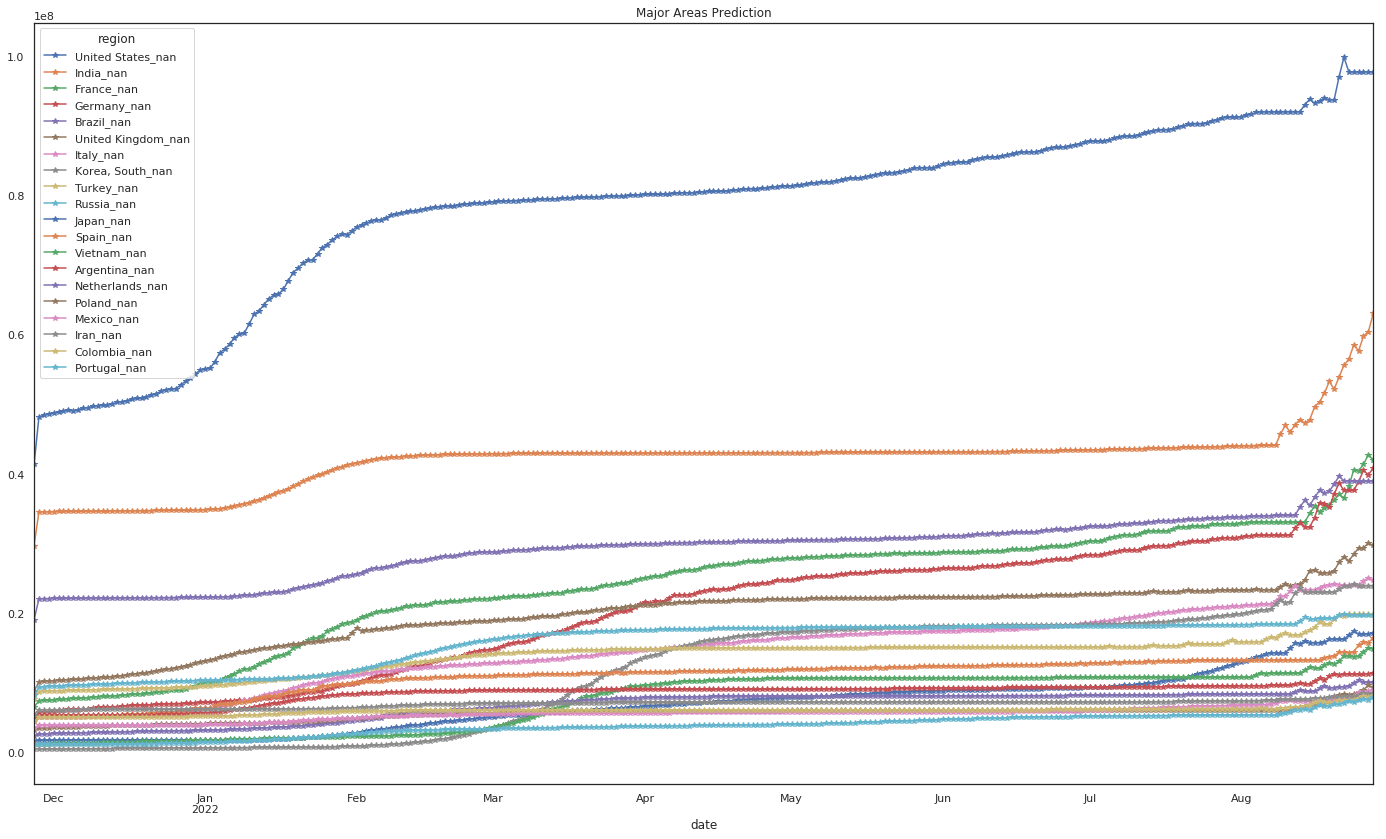

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

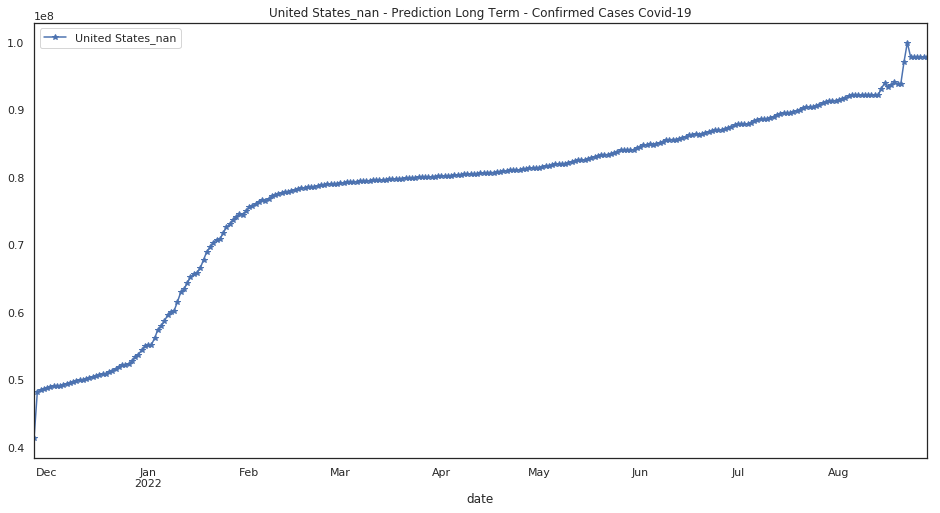

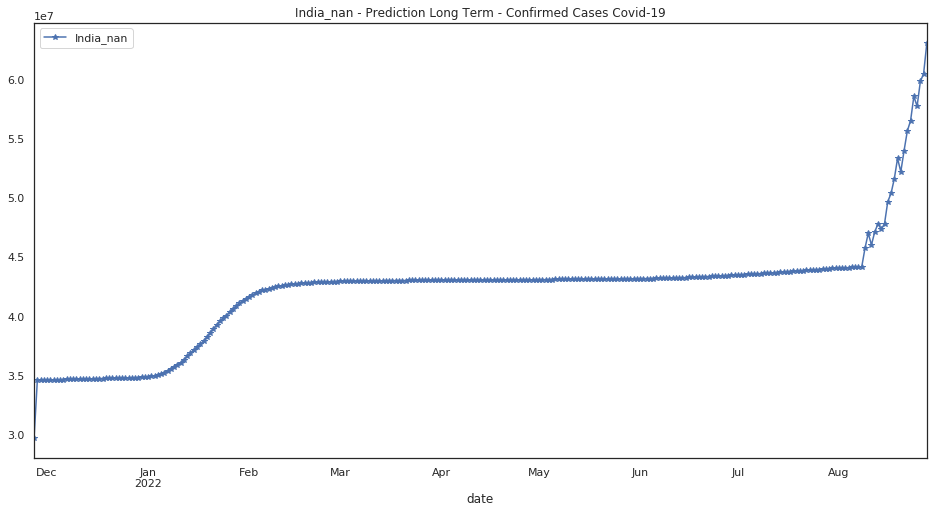

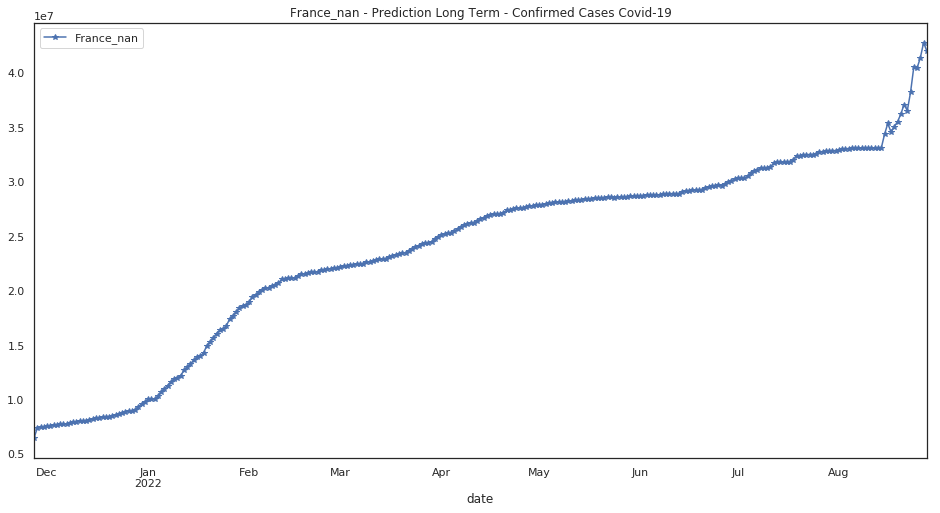

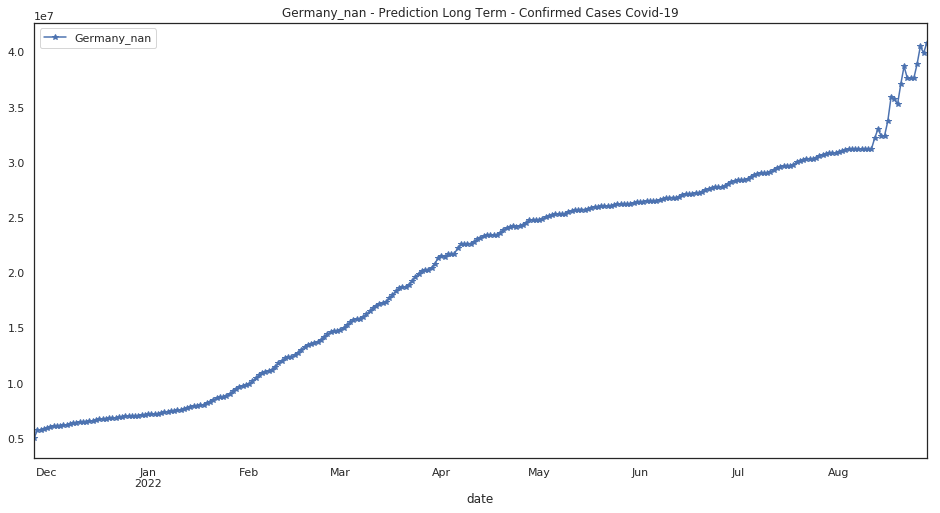

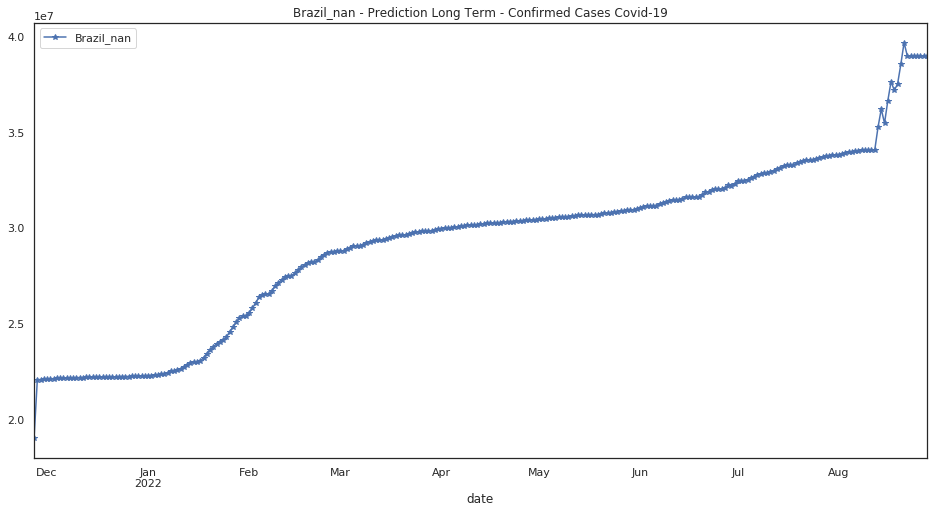

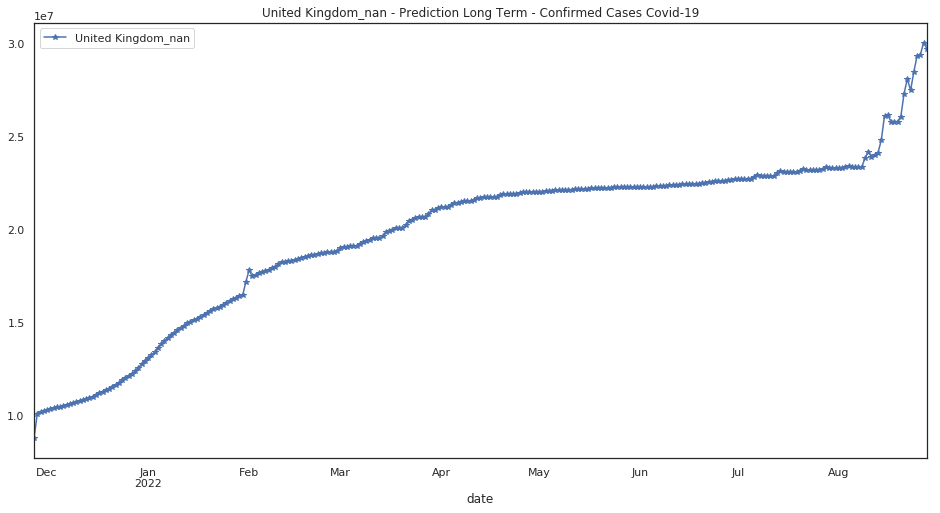

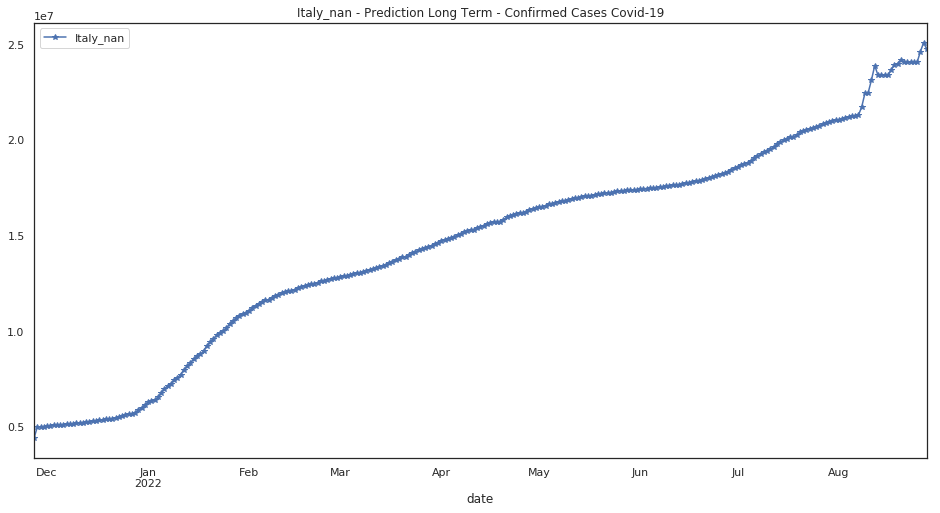

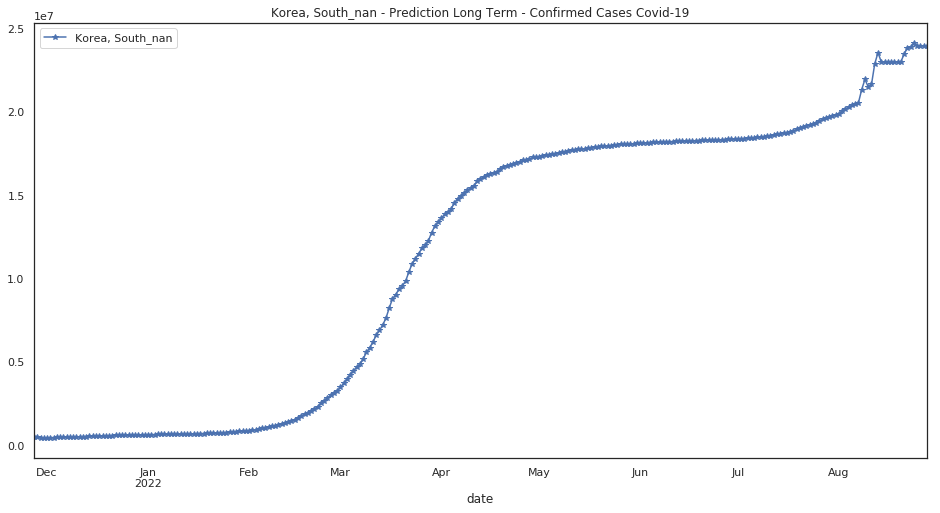

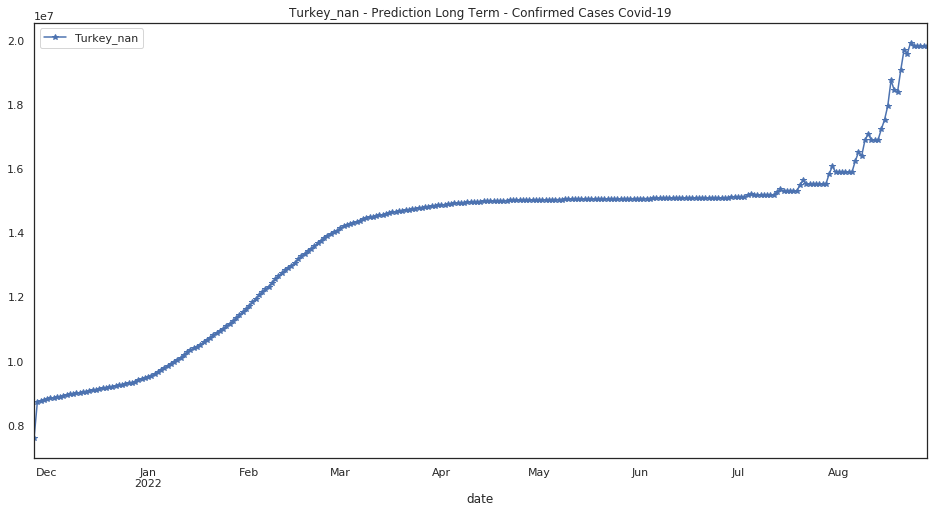

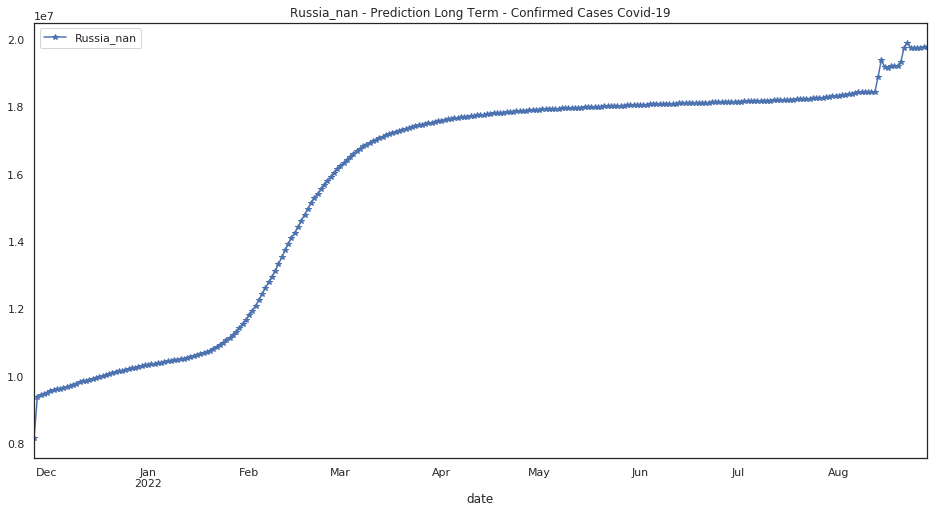

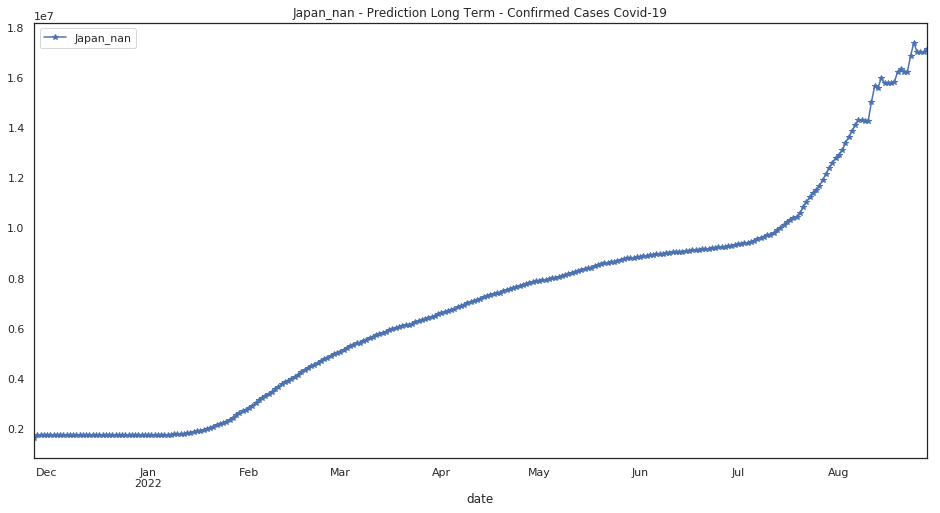

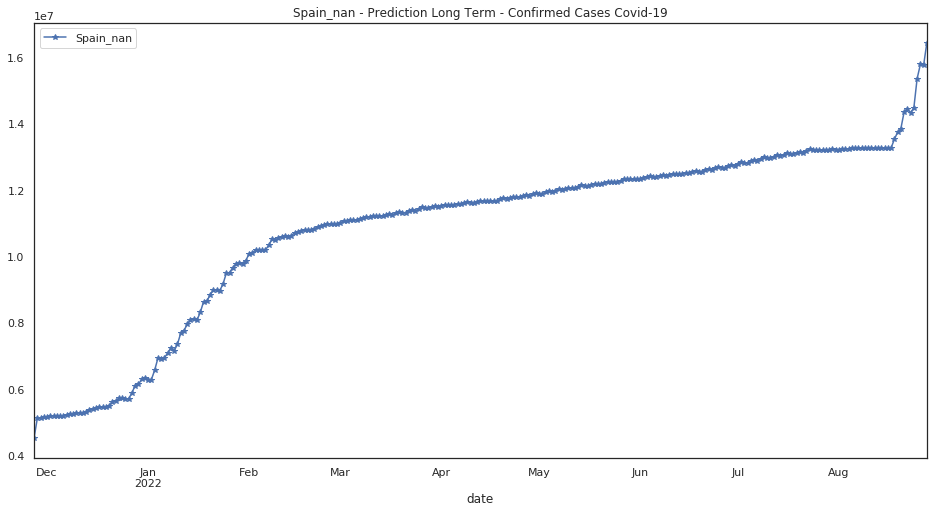

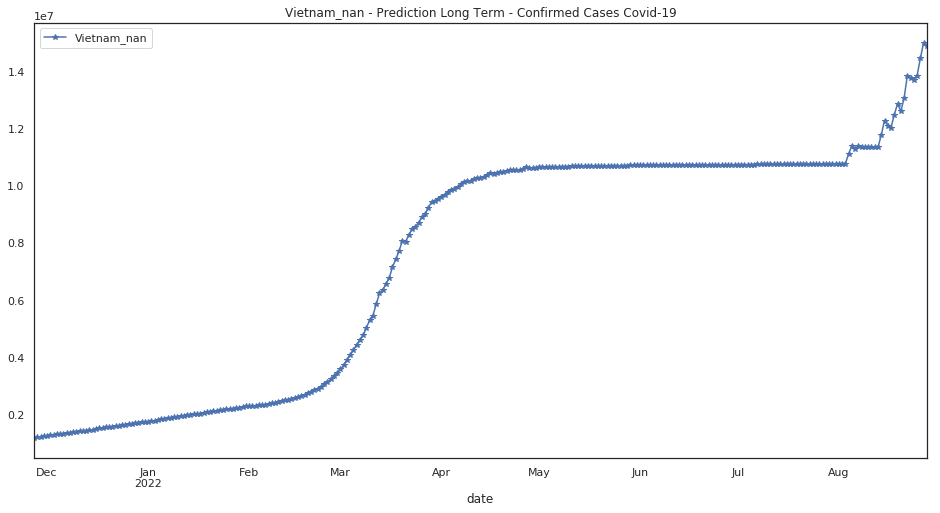

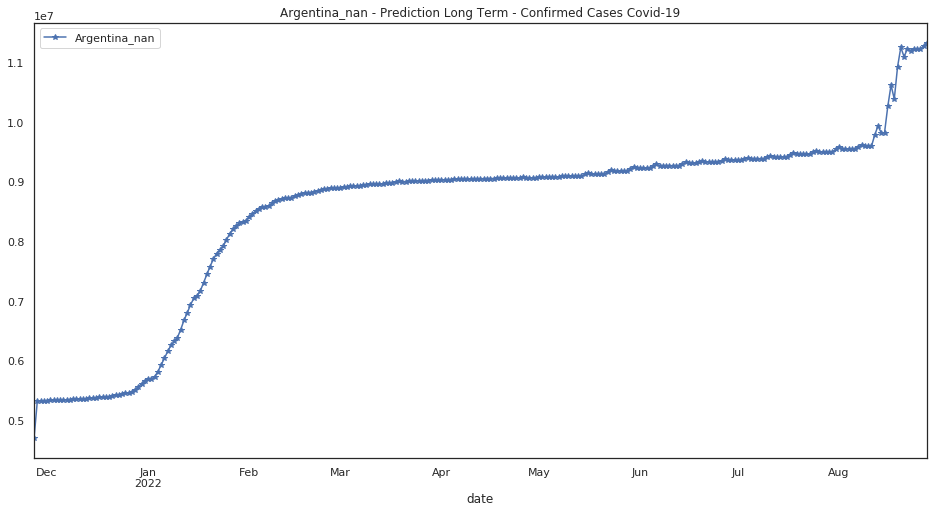

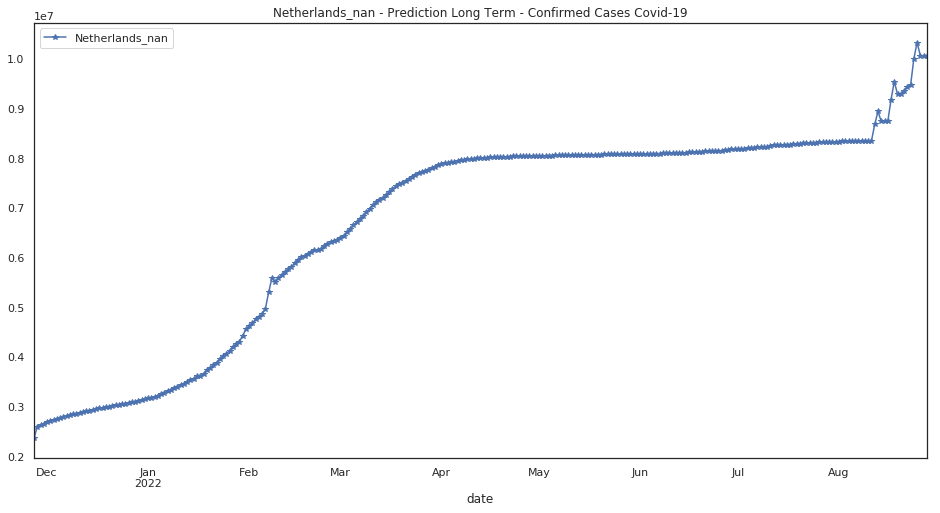

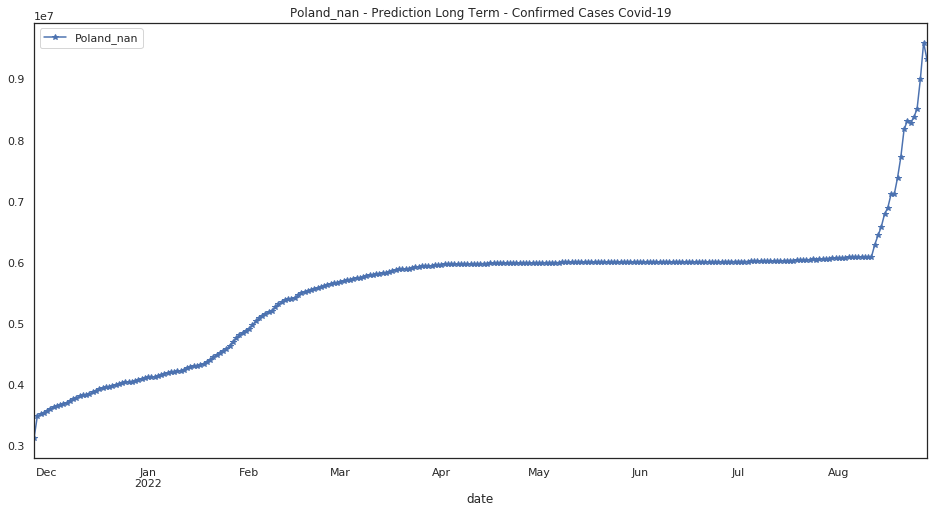

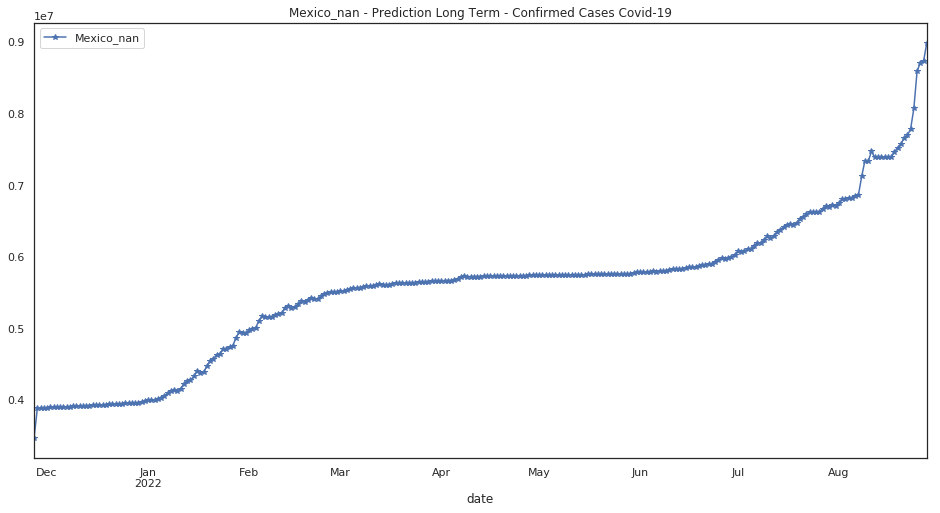

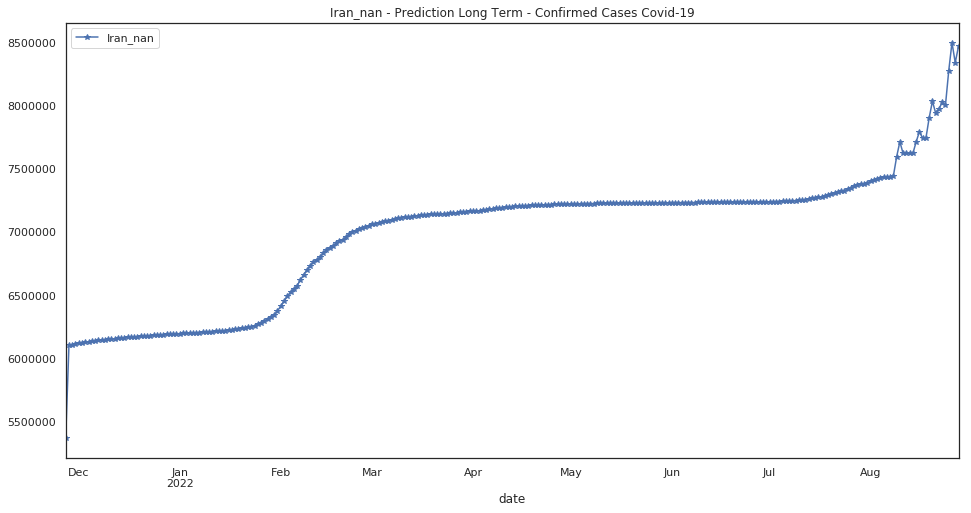

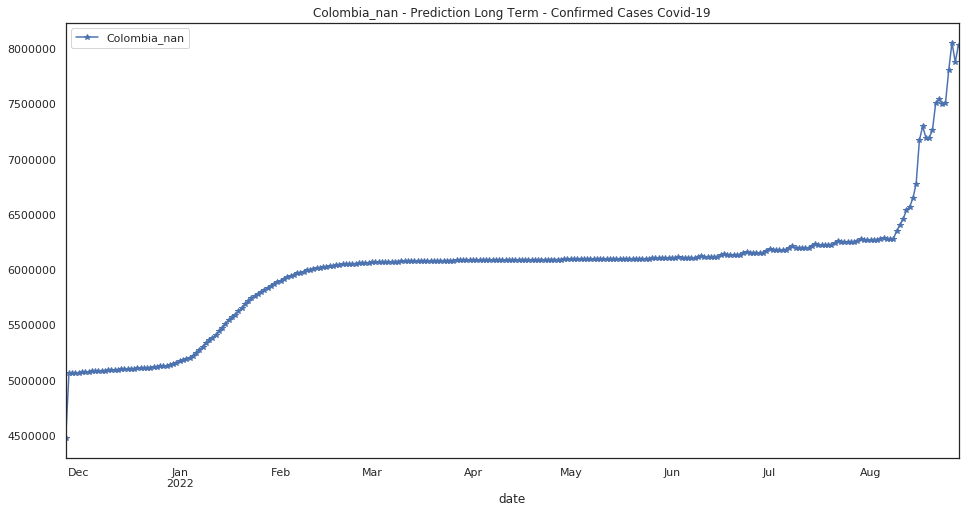

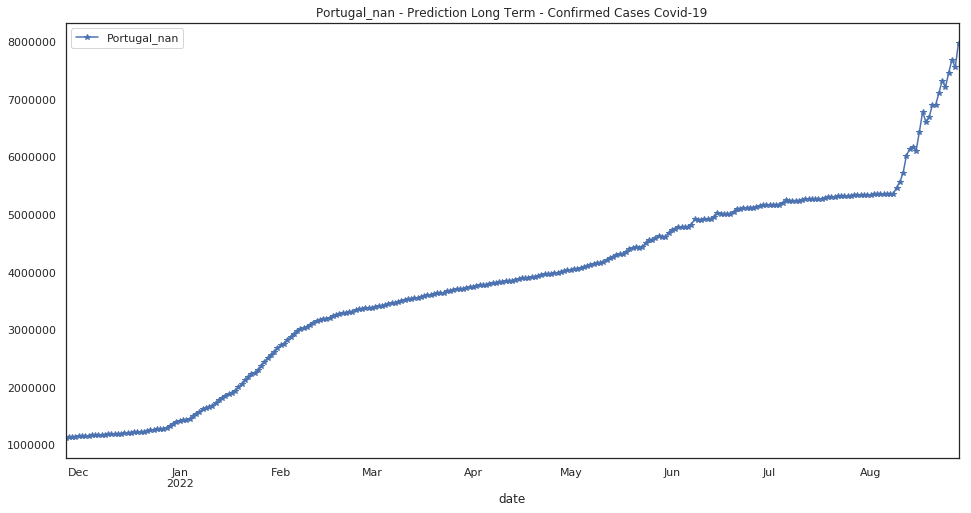

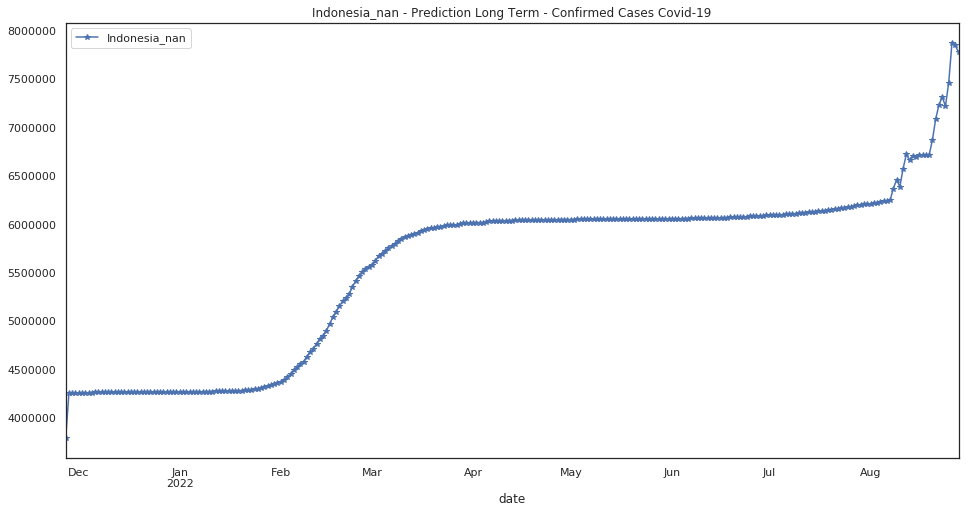

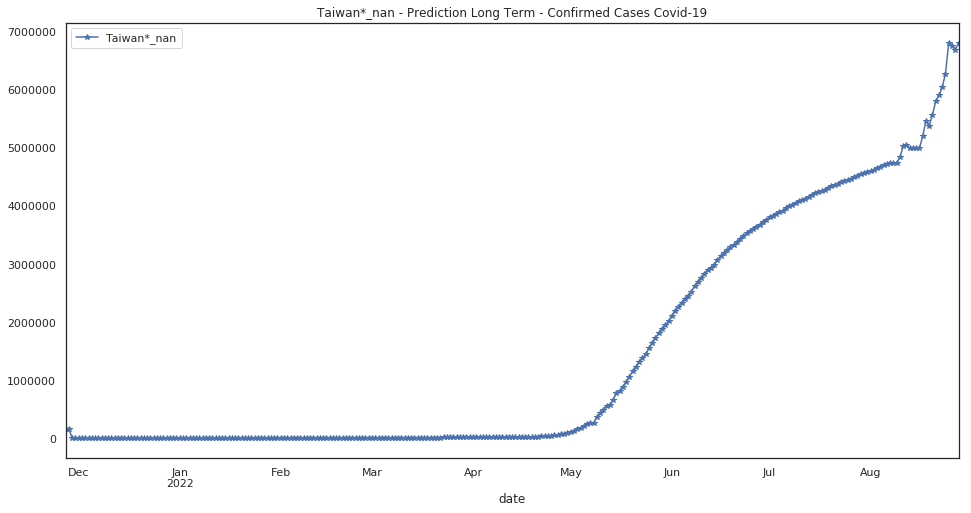

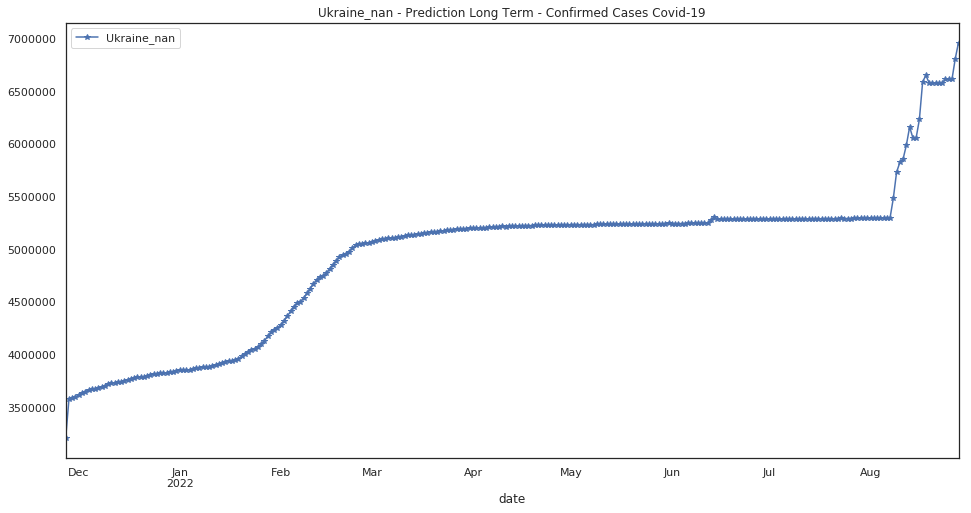

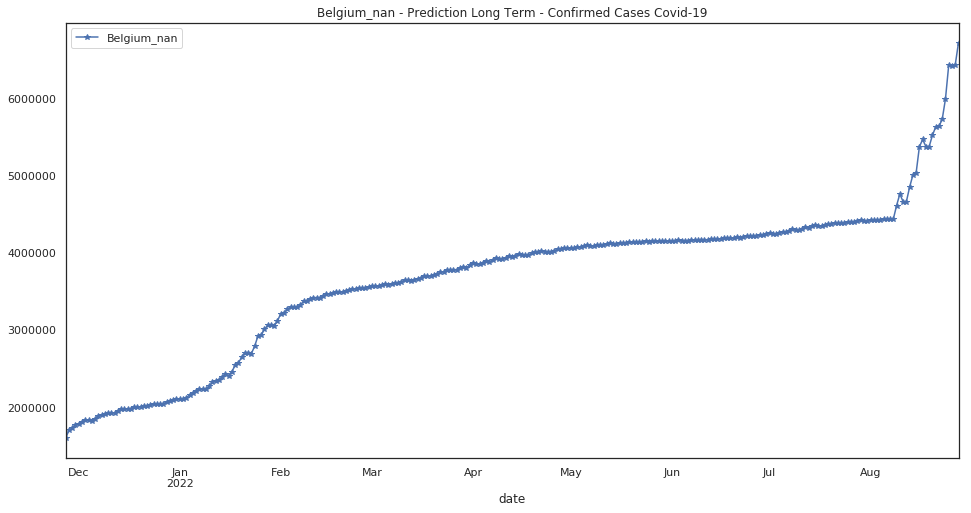

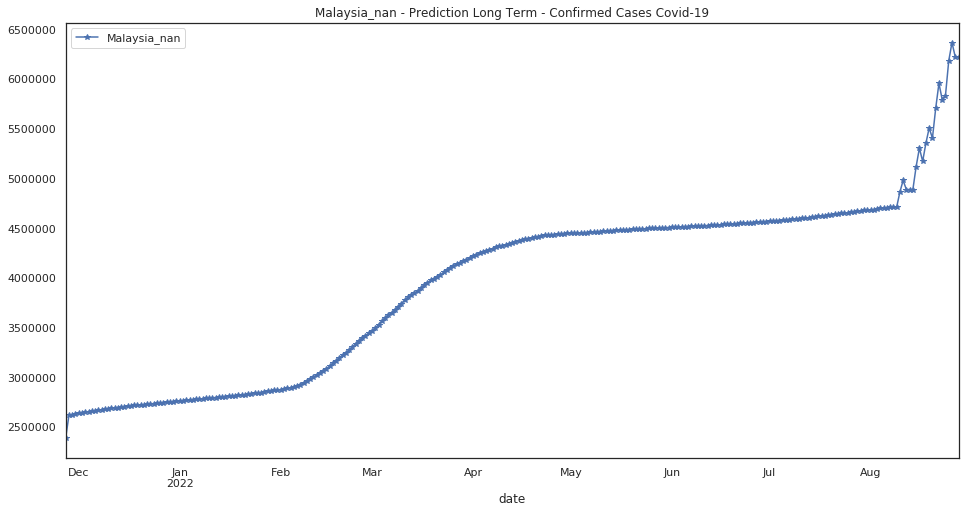

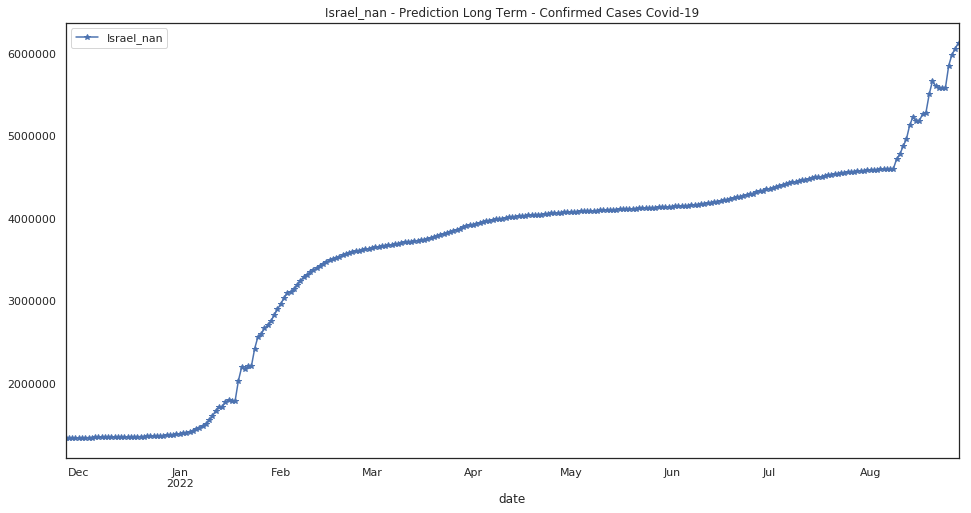

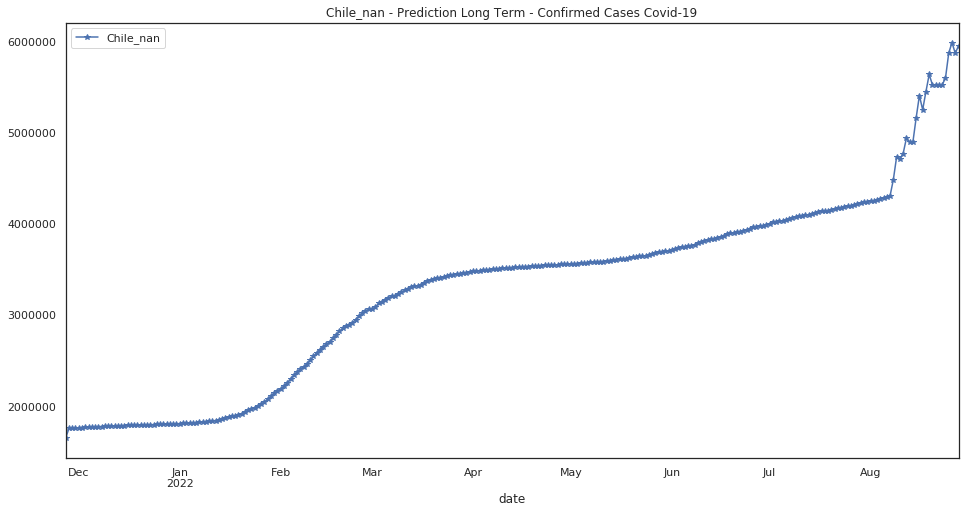

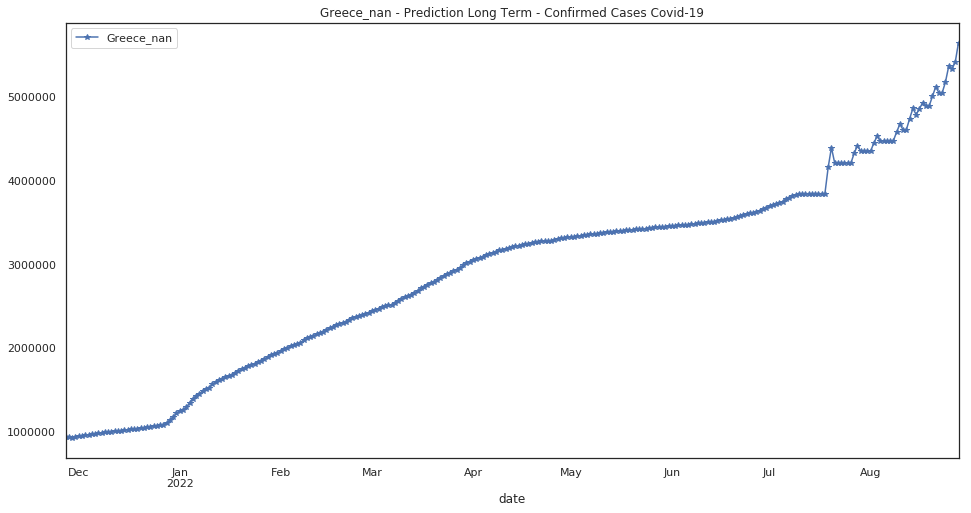

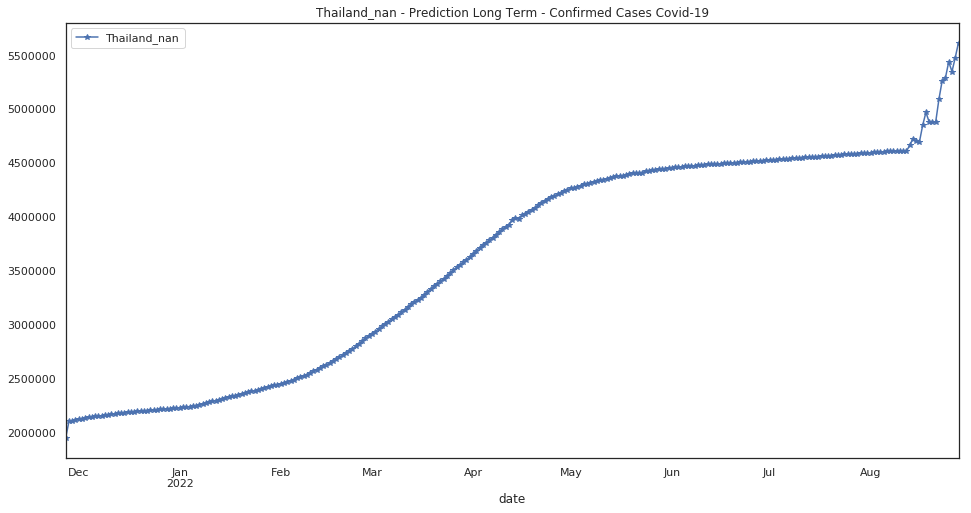

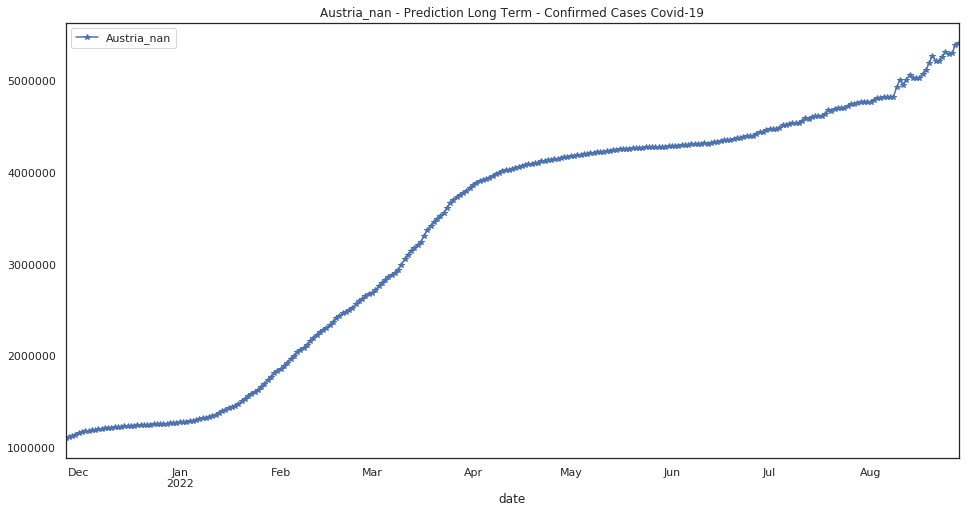

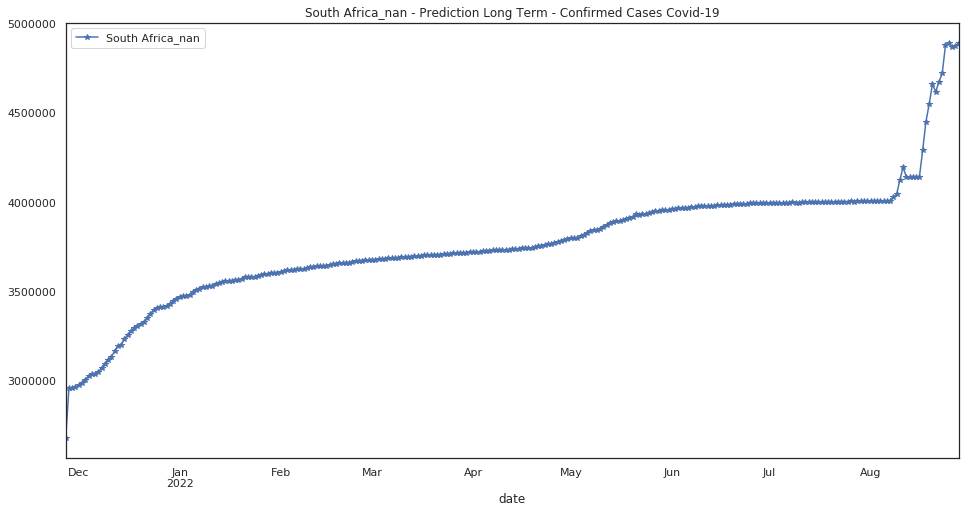

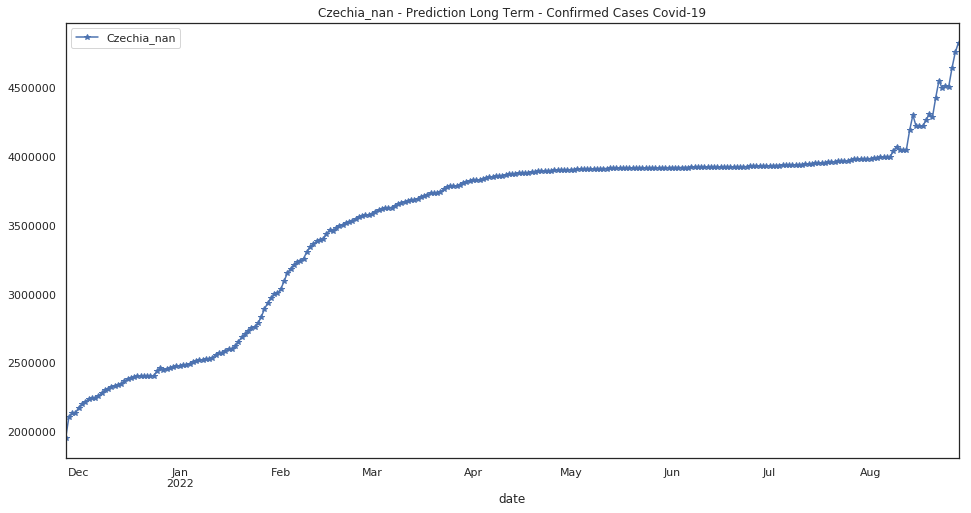

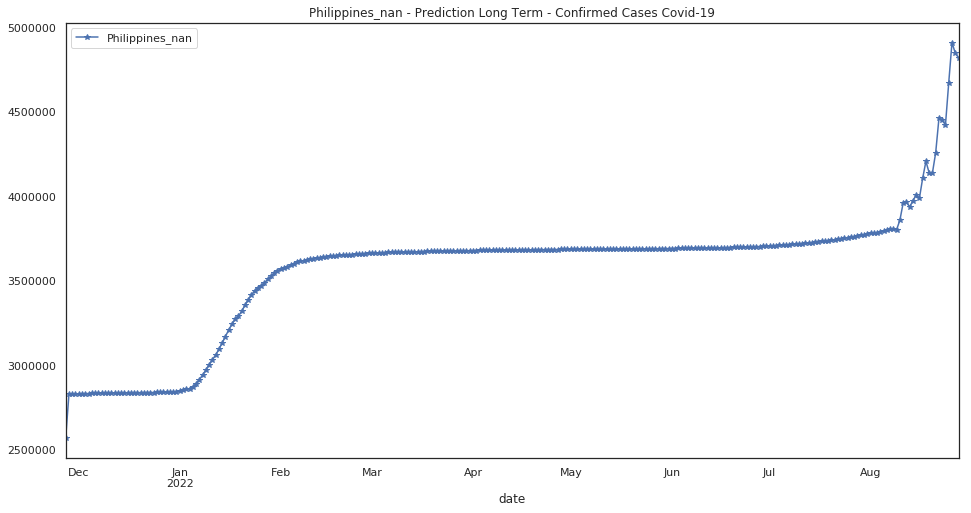

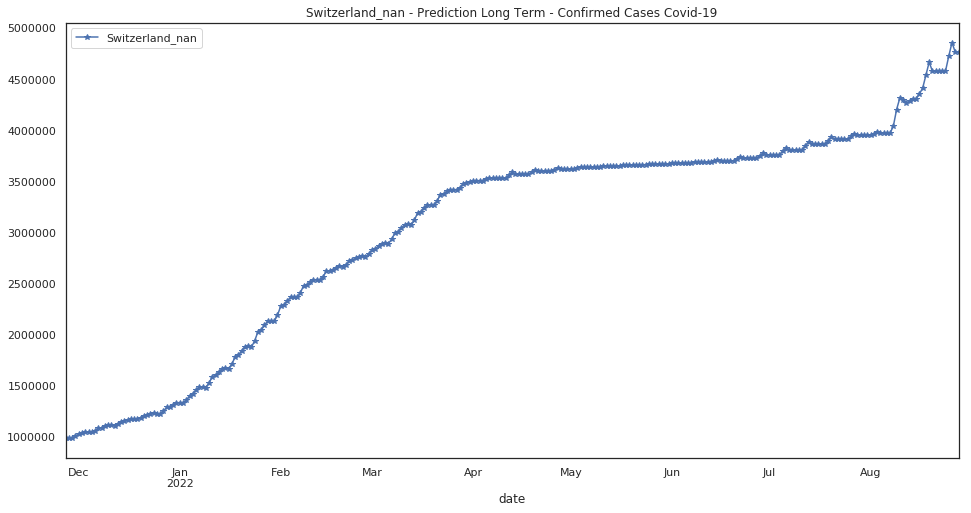

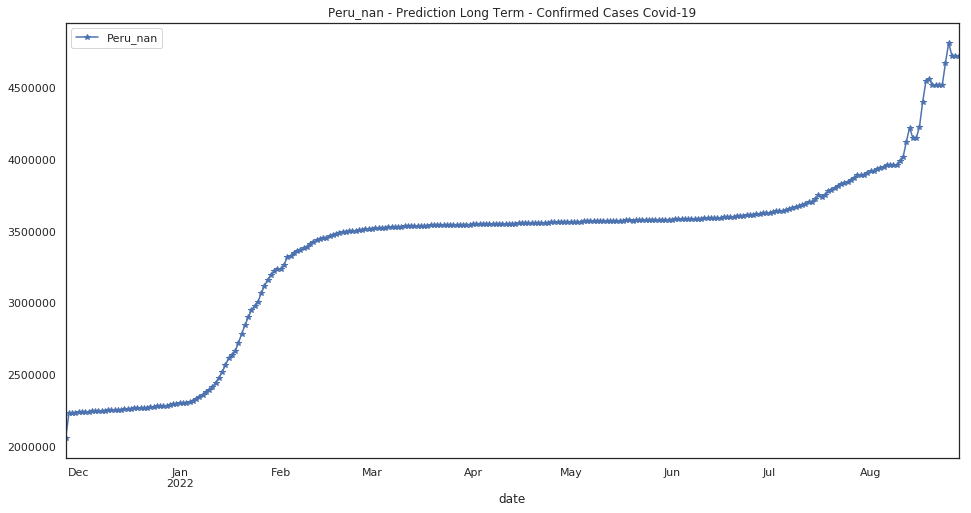

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

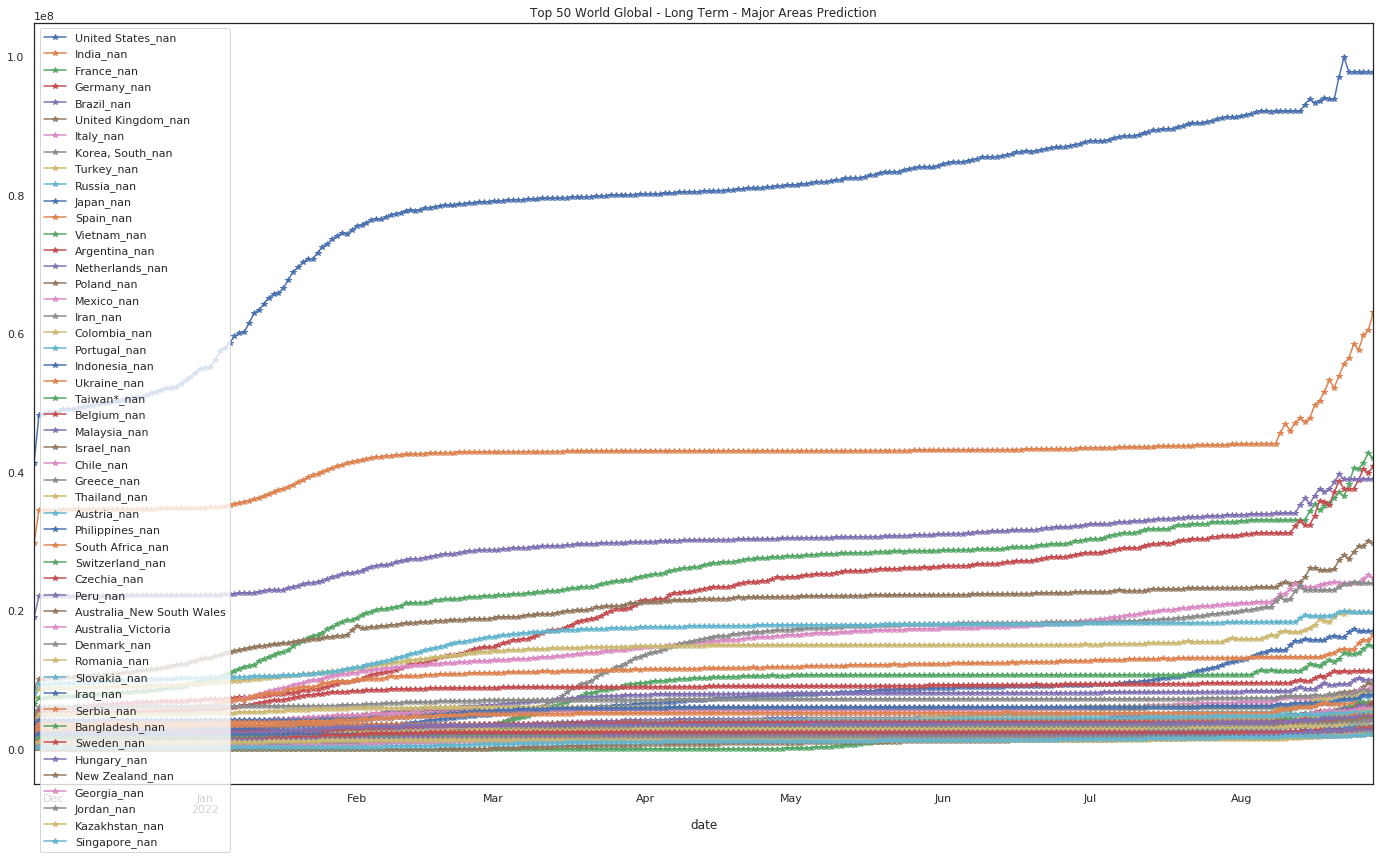

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

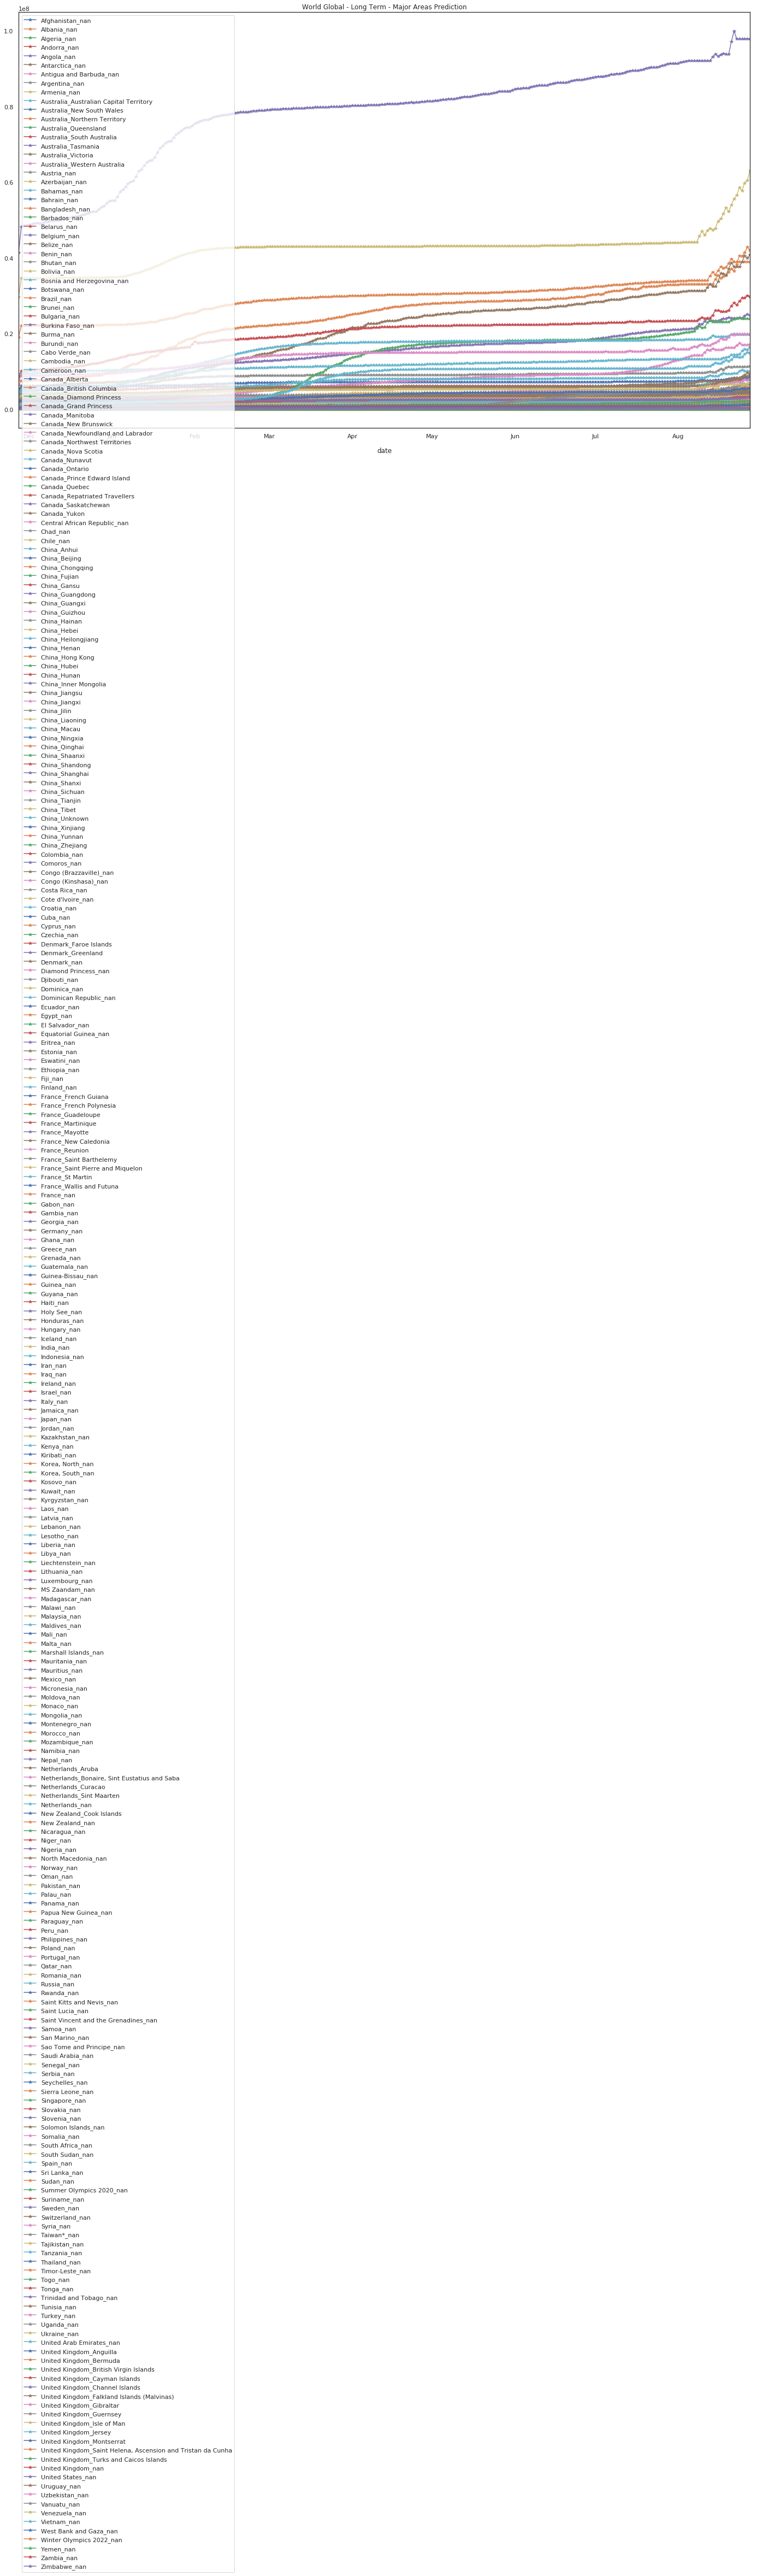

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2022-01-11         160698.0     223825.0     225193.0      27983.0   
2022-01-12         160719.0     225650.0     225786.0      28542.0   
2022-01-13         160816.0     227450.0     226365.0      28899.0   
2022-01-14         160842.0     229621.0     226959.0      30199.0   
2022-01-15         160900.0     231746.0     227472.0      29888.0   
2022-01-16         160937.0     233422.0     228037.0      30252.0   
2022-01-17         161033.0     234727.0     228696.0      30252.0   
2022-01-18         161147.0     237291.0     229470.0      29888.0   
2022-01-19         161239.0     239794.0     230740.0      29888.0   
2022-01-20         161475.0     242252.0     232208.0      31733.0   
2022-01-21         161637.0     244958.0     233997.0      32201.0   
2022-01-22         161700.0     247203.0     236120.0      33025.0   
2022-01-23         161861.0     248954.0     238194.0      33835.0   
2022-01-24         162046.0     249196.0     240363.0      33025.0   
2022-01-25         162323.0     249881.0     242782.0      34136.0   
2022-01-26         162720.0     251836.0     244910.0      34701.0   
2022-01-27         163025.0     253465.0     247040.0      35028.0   
2022-01-28         163169.0     255162.0     248923.0      35616.0   
2022-01-29         163466.0     255481.0     250673.0      35556.0   
2022-01-30         164106.0     256935.0     252193.0      35556.0   
2022-01-31         164690.0     259513.0     253573.0      35556.0   
2022-02-01         165379.0     259792.0     254996.0      35958.0   
2022-02-02         166103.0     262218.0     256408.0      35958.0   
2022-02-03         166631.0     262563.0     257460.0      36315.0   
2022-02-04         167258.0     264227.0     258487.0      36470.0   
2022-02-05         167590.0     264539.0     259332.0      36599.0   
2022-02-06         168132.0     265688.0     259800.0      36599.0   
2022-02-07         168793.0     266167.0     260326.0      36599.0   
2022-02-08         169514.0     266996.0     260941.0      36808.0   
2022-02-09         170321.0     267703.0     261561.0      36808.0   
...                     ...          ...          ...          ...   
2022-07-30         187724.0     312597.0     269556.0      45508.0   
2022-07-31         187903.0     313348.0     269636.0      45508.0   
2022-08-01         188053.0     313658.0     269725.0      45508.0   
2022-08-02         188254.0     314660.0     269832.0      45508.0   
2022-08-03         188524.0     315781.0     269951.0      45508.0   
2022-08-04         188802.0     316592.0     270075.0      45793.0   
2022-08-05         189127.0     317420.0     270205.0      45793.0   
2022-08-06         189225.0     318249.0     270315.0      45793.0   
2022-08-07         189578.0     318835.0     270426.0      45793.0   
2022-08-08         189554.0     326234.0     270440.0      45793.0   
2022-08-09         189628.0     328047.0     274518.0      46110.0   
2022-08-10         189633.0     337106.0     275164.0      46110.0   
2022-08-11         197779.0     339805.0     275158.0      47663.0   
2022-08-12         199094.0     338277.0     279099.0      47663.0   
2022-08-13         201403.0     338321.0     289807.0      47734.0   
2022-08-14         211764.0     346095.0     291608.0      47999.0   
2022-08-15         211072.0     349658.0     292252.0      49952.0   
2022-08-16         212784.0     349302.0     292237.0      49952.0   
2022-08-17         212784.0     349110.0     291943.0      50464.0   
2022-08-18         220876.0     349419.0     292083.0      50464.0   
2022-08-19         221292.0     349372.0     296824.0      51244.0   
2022-08-20         222978.0     349372.0     298053.0      53446.0   
2022-08-21         222978.0     365170.0     298434.0      53446.0   
2022-08-22         222994.0     370500.0     304601.0      54540.0   
2022-08-23

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                                       Antarctica_nan -71.949900   23.347000   
6                              Antigua and Barbuda_nan  17.060800  -61.796400   
7                                        Argentina_nan -38.416100  -63.616700   
8                                          Armenia_nan  40.069100   45.038200   
9               Australia_Australian Capital Territory -35.473500  149.012400   
10                           Australia_New South Wales -33.868800  151.209300   
11                        Australia_Northern Territory -12.463400  130.845600   
12                                Australia_Queensland -27.469800  153.025100   
13                           Australia_South Australia -34.928500  138.600700   
14                                  Australia_Tasmania -42.882100  147.327200   
15                                  Australia_Victoria -37.813600  144.963100   
16                         Australia_Western Australia -31.950500  115.860500   
17                                         Austria_nan  47.516200   14.550100   
18                                      Azerbaijan_nan  40.143100   47.576900   
19                                         Bahamas_nan  25.025885  -78.035889   
20                                         Bahrain_nan  26.027500   50.550000   
21                                      Bangladesh_nan  23.685000   90.356300   
22                                        Barbados_nan  13.193900  -59.543200   
23                                         Belarus_nan  53.709800   27.953400   
24                                         Belgium_nan  50.833300    4.469936   
25                                          Belize_nan  17.189900  -88.497600   
26                                           Benin_nan   9.307700    2.315800   
27                                          Bhutan_nan  27.514200   90.433600   
28                                         Bolivia_nan -16.290200  -63.588700   
29                          Bosnia and Herzegovina_nan  43.915900   17.679100   
..                                                 ...        ...         ...   
261                                        Tunisia_nan  33.886917    9.537499   
262                                         Turkey_nan  38.963700   35.243300   
263                                  United States_nan  40.000000 -100.000000   
264                                         Uganda_nan   1.373333   32.290275   
265                                        Ukraine_nan  48.379400   31.165600   
266                           United Arab Emirates_nan  23.424076   53.847818   
267                            United Kingdom_Anguilla  18.220600  -63.068600   
268                             United Kingdom_Bermuda  32.307800  -64.750500   
269              United Kingdom_British Virgin Islands  18.420700  -64.640000   
270                      United Kingdom_Cayman Islands  19.313300  -81.254600   
271                     United Kingdom_Channel Islands  49.372300   -2.364400   
272         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
273                           United Kingdom_Gibraltar  36.140800   -5.353600   
274                            United Kingdom_Guernsey  49.448196   -2.589490   
275                         United Kingdom_Isle of Man  54.236100   -4.548100   
276                              United Kingdom_Jersey  49.213800   -2.135800   
277                          United Kingdom_Montserrat  16.742498  -62.187366   
278  United Kingdom_Saint Helena, Ascension and Tri...  -7.946700  -14.355900  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                     region        Lat        Long  \
0       7              Argentina_nan -38.416100  -63.616700   
1      10  Australia_New South Wales -33.868800  151.209300   
2      15         Australia_Victoria -37.813600  144.963100   
3      17                Austria_nan  47.516200   14.550100   
4      21             Bangladesh_nan  23.685000   90.356300   
5      24                Belgium_nan  50.833300    4.469936   
6      31                 Brazil_nan -14.235000  -51.925300   
7      60                  Chile_nan -35.675100  -71.543000   
8      95               Colombia_nan   4.570900  -74.297300   
9     104                Czechia_nan  49.817500   15.473000   
10    107                Denmark_nan  56.263900    9.501800   
11    133                 France_nan  46.227600    2.213700   
12    136                Georgia_nan  42.315400   43.356900   
13    137                Georgia_nan  42.315400   43.356900   
14    138                Germany_nan  51.165691   10.451526   
15    140                 Greece_nan  39.074200   21.824300   
16    150                Hungary_nan  47.162500   19.503300   
17    152                  India_nan  20.593684   78.962880   
18    153              Indonesia_nan  -0.789300  113.921300   
19    154                   Iran_nan  32.427908   53.688046   
20    155                   Iraq_nan  33.223191   43.679291   
21    157                 Israel_nan  31.046051   34.851612   
22    158                 Israel_nan  31.046051   34.851612   
23    159                  Italy_nan  41.871940   12.567380   
24    161                  Japan_nan  36.204824  138.252924   
25    162                 Jordan_nan  31.240000   36.510000   
26    163             Kazakhstan_nan  48.019600   66.923700   
27    167           Korea, South_nan  35.907757  127.766922   
28    184               Malaysia_nan   4.210484  101.975766   
29    191                 Mexico_nan  23.634500 -102.552800   
30    205            Netherlands_nan  52.132600    5.291300   
31    207            New Zealand_nan -40.900600  174.886000   
32    219                   Peru_nan  -9.190000  -75.015200   
33    220            Philippines_nan  12.879721  121.774017   
34    221                 Poland_nan  51.919400   19.145100   
35    222               Portugal_nan  39.399900   -8.224500   
36    224                Romania_nan  45.943200   24.966800   
37    225                 Russia_nan  61.524010  105.318756   
38    235                 Serbia_nan  44.016500   21.005900   
39    238              Singapore_nan   1.283300  103.833300   
40    239               Slovakia_nan  48.669000   19.699000   
41    243           South Africa_nan -30.559500   22.937500   
42    245                  Spain_nan  40.463667   -3.749220   
43    250                 Sweden_nan  60.128161   18.643501   
44    251            Switzerland_nan  46.818200    8.227500   
45    253                Taiwan*_nan  23.700000  121.000000   
46    256               Thailand_nan  15.870032  100.992541   
47    262                 Turkey_nan  38.963700   35.243300   
48    263          United States_nan  40.000000 -100.000000   
49    265                Ukraine_nan  48.379400   31.165600   
50    280         United Kingdom_nan  55.378100   -3.436000   
51    285                Vietnam_nan  14.058324  108.277199   

    2021-11-27 00:00:00  2021-11-28 00:00:00  2021-11-29 00:00:00  \
0             4704255.0            5325560.0            5326448.0   
1              219296.0             219420.0              81499.0   
2              252188.0             253043.0             120814.0   
3             1106077.0            1118256.0            1131658.0   
4             1497189.0            1575579.0            1575784.0   
5             1604994.0            1701633.0            1729928.0   
6            19034585.0           22081833.0           22085369.0   
7             1652410.0            1757077.0            1759405.0   
8             4479859.0            5063177.

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()